In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def create_circuit(n_qubits,n_layers=None,circ = "simplified_two_design",fim=False, shots=None):

    dev = qml.device("lightning.qubit", wires=n_qubits, shots=shots)

    def RZRY(params):
        #qml.SpecialUnitary(params, wires=range(n_qubits))
        #qml.SimplifiedTwoDesign(initial_layer_weights=init_params, weights=params, wires=range(n_qubits))
        #qml.AngleEmbedding(params,wires=range(n_qubits))
        for q in range(n_qubits):
            qml.Hadamard(wires=q)

        for w in range(n_layers): 
            for q in range(n_qubits):
                index = w * (2*n_qubits) + q * 2
                qml.RZ(params[index],wires=q)
                qml.RY(params[index + 1],wires=q)
        
        qml.broadcast(qml.CZ , wires=range(n_qubits), pattern="all_to_all")
        
        return qml.probs(wires=range(n_qubits))

    def S2D(init_params,params,measurement_qubits=0,prod_approx=False):
        #qml.SpecialUnitary(params, wires=range(n_qubits))
        qml.SimplifiedTwoDesign(initial_layer_weights=init_params, weights=params, wires=range(n_qubits))
        
        #qml.broadcast(qml.CNOT , wires=range(n_qubits), pattern="all_to_all")
        if not prod_approx:
            return qml.probs(wires=range(measurement_qubits))
        else:
            return [qml.probs(i) for i in range(measurement_qubits)]

    def SU(params):
        qml.SpecialUnitary(params, wires=range(n_qubits))
        
        ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
        for i in range(2,n_qubits):
            ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))

        return qml.expval(ZZ)
    
    def simmpleRZRY(params,cnots=True,measurement_qubits=0,sample=False):
        qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        

        qml.broadcast(qml.RZ, wires=range(n_qubits), pattern="single", parameters=params[0])
        qml.broadcast(qml.RY, wires=range(n_qubits), pattern="single", parameters=params[1])

        qml.broadcast(qml.CZ, wires=list(range(n_qubits)), pattern="all_to_all")
 
        return qml.probs(wires=range(measurement_qubits))
        
    def RY(params,y=True,probs=False,prod=False, entanglement=None,measurement_qubits=0):
        qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        qml.broadcast(qml.RY, wires=range(n_qubits), pattern="single", parameters=params)
        #qml.broadcast(qml.CZ, wires=range(n_qubits), pattern="all_to_all")

        if entanglement=="all_to_all":
            qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="all_to_all")
        
        if y==True:
            #YY = qml.operation.Tensor(qml.PauliY(0), qml.PauliY(1))
            YY = [qml.PauliZ(0), qml.PauliZ(1)]
            for i in range(2,n_qubits):
                #YY = qml.operation.Tensor(YY, qml.PauliY(i))
                YY.append(qml.PauliZ(i))
            
            #return [qml.expval(i) for i in YY]
            return qml.expval(YY)

        elif probs==False:

            ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
            #ZZ = [qml.PauliZ(0), qml.PauliZ(1)]
            for i in range(2,n_qubits):
                ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))        
                #ZZ.append(qml.PauliZ(i))        

            #return [qml.expval(i) for i in ZZ]
            return qml.expval(ZZ)

        else:
            if prod:
                return [qml.probs(i) for i in range(n_qubits)]
            else:
                return qml.probs(wires=range(measurement_qubits))
        
    def GHZ(params,measurement_qubits=0):
        qml.RY(params,wires=0)
        qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")

        return qml.probs(wires=range(measurement_qubits))

    def random_product_state(params,gate_sequence=None):
                
        for i in range(n_qubits):
            qml.RY(np.pi / 4, wires=i)

        for ll in range(len(params)):

            for i in range(n_qubits):
                gate_sequence["{}{}".format(ll,i)](params[ll][i], wires=i)

            #for i in range(n_qubits - 1):
                #qml.CZ(wires=[i, i + 1])
    def SEL(params, measurement_qubits=0):
        qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
        return qml.probs(wires=range(measurement_qubits))
    
    if circ == "rzry":
        qcircuit = RZRY
    elif circ == "simplified_two_design":
        qcircuit = S2D
    elif circ == "special_unitary":
        qcircuit = SU
    elif circ == "simpleRZRY":
        qcircuit = simmpleRZRY
    elif circ == "RY":
        qcircuit = RY
    elif circ == "ghz":
        qcircuit = GHZ
    elif circ == "random_product_state":
        qcircuit = random_product_state
    elif circ == "SEL":
        qcircuit = SEL
    if not fim:
        circuit = qml.QNode(qcircuit, dev,interface="torch", diff_method="best")
    else:
        circuit = qml.QNode(qcircuit, dev)

    return circuit

In [3]:
def compute_gradient(log_prob, w):
    """Compute gradient of the log probability with respect to weights.
    
    Args:
    - log_prob (torch.Tensor): The log probability tensor.
    - w (torch.Tensor): The weights tensor, with requires_grad=True.

    Returns:
    - numpy.ndarray: The gradient of log_prob with respect to w, flattened.
    """
    if w.grad is not None:
        w.grad.zero_()
    log_prob.backward(retain_graph=True)
    
    if w.grad is None:
        raise ValueError("The gradient for the given log_prob with respect to w is None.")
    
    return w.grad.view(-1).detach().numpy()

### Simplified 2 design log prob gradient as a function of $|A|$ 

In [119]:
qubits = [4,6,8,10,12,14]
n_layers = 5
n_samples = 1000


var_gradients_qubits = []
var_gradients_no_clamp = []

for n_qubits in qubits:
    var_gradients_actions = []
    var_gradients_actions_no_clamp = []
    print("-Starting with {} qubits".format(n_qubits))

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    if n_qubits <= 10:
        actions = [2**i for i in range(1,n_qubits)]
    else:
        actions = [2**i for i in range(1,10)] + [2**n_qubits]
    
    for n_actions in actions:
        print("---Starting with ",n_actions," actions")
        gradients = []
        gradients_no_clamp = []
        for s in range(n_samples):
        
            weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]
            weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
            weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
            #param=torch.rand(1,requires_grad=True)  
            qc = create_circuit(n_qubits,circ="simplified_two_design")
            #qc = create_circuit(n_qubits,circ="ghz")
            measure_qubits = int(np.log2(n_actions))    
            probs = qc(weights_tensor_init, weights_tensor_params, measurement_qubits=measure_qubits)
            #probs = qc(param, measurement_qubits=measure_qubits)[0]
            #policy = torch.sum(probs[:int((2**n_qubits)/n_actions)])
            index = np.random.randint(2**measure_qubits)
            policy = probs[-1]
            gradients_no_clamp.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))

            #poly(n_qubits) clipping the policy
            policy = torch.clamp(policy,(1/n_qubits),1)


            gradients.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))
            #gradients.append(compute_gradient(torch.log(policy), param))
        
        var_gradients_actions.append(np.var(gradients))
        var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))
    var_gradients_qubits.append(var_gradients_actions)
    var_gradients_no_clamp.append(var_gradients_actions_no_clamp)


-Starting with 4 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
-Starting with 6 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
---Starting with  16  actions
---Starting with  32  actions
-Starting with 8 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
---Starting with  16  actions
---Starting with  32  actions
---Starting with  64  actions
---Starting with  128  actions
-Starting with 10 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
---Starting with  16  actions
---Starting with  32  actions
---Starting with  64  actions
---Starting with  128  actions
---Starting with  256  actions
---Starting with  512  actions
-Starting with 12 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
---Starting with  16  actions
---Starting with  32  actions
---Starting with  6

In [121]:
np.save("var_gradients_contiguous_clamp_f(A).npy",var_gradients_qubits)
#np.save("var_gradients_contiguous_no_clamp_f(A).npy",var_gradients_no_clamp)

/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


### for $|A|= 2^n$

In [124]:
qubits = [4,6,8,10,12,14]
n_layers = 5
n_samples = 1000


#var_gradients_qubits = []
var_gradients_no_clamp = []

for n_qubits in qubits:
    var_gradients_actions = []
    var_gradients_actions_no_clamp = []
    print("-Starting with {} qubits".format(n_qubits))

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    actions = [2**n_qubits]
    
    for n_actions in actions:
        print("---Starting with ",n_actions," actions")
        #gradients = []
        gradients_no_clamp = []
        for s in range(n_samples):
        
            weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]
            weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
            weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
            #param=torch.rand(1,requires_grad=True)  
            qc = create_circuit(n_qubits,circ="simplified_two_design")
            #qc = create_circuit(n_qubits,circ="ghz")
            measure_qubits = int(np.log2(n_actions))    
            probs = qc(weights_tensor_init, weights_tensor_params, measurement_qubits=measure_qubits)
            #probs = qc(param, measurement_qubits=measure_qubits)[0]
            #policy = torch.sum(probs[:int((2**n_qubits)/n_actions)])
            index = np.random.randint(2**measure_qubits)
            policy = probs[-1]
            gradients_no_clamp.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))

            #poly(n_qubits) clipping the policy
            #policy = torch.clamp(policy,0.1,1)

            #gradients.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))
            #gradients.append(compute_gradient(torch.log(policy), param))
        
        #var_gradients_actions.append(np.var(gradients))
        var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))
    #var_gradients_qubits.append(var_gradients_actions)
    var_gradients_no_clamp+=var_gradients_actions_no_clamp


-Starting with 4 qubits
---Starting with  16  actions
-Starting with 6 qubits
---Starting with  64  actions
-Starting with 8 qubits
---Starting with  256  actions
-Starting with 10 qubits
---Starting with  1024  actions
-Starting with 12 qubits
---Starting with  4096  actions
-Starting with 14 qubits
---Starting with  16384  actions


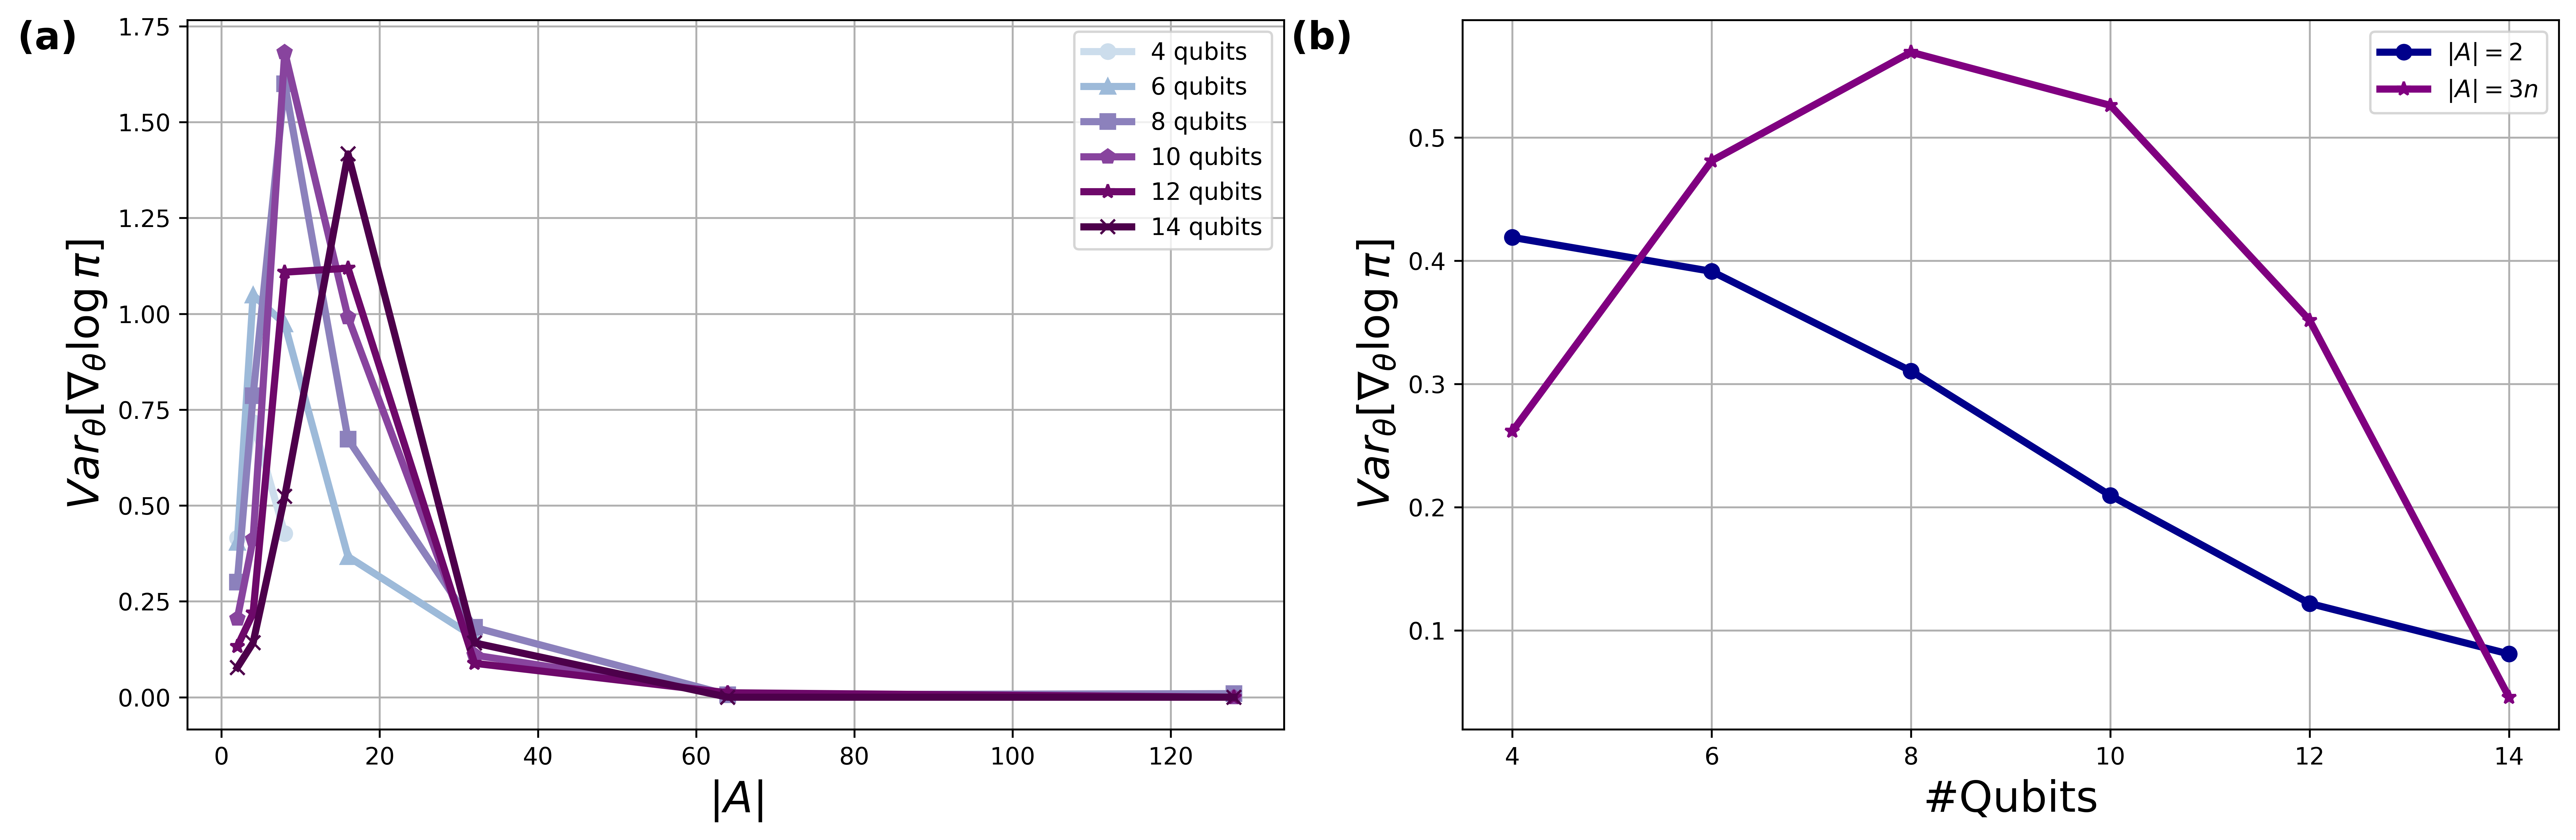

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

var_gradients_qubits = np.load("var_gradients_contiguous_clamp_f(A).npy",allow_pickle=True)
var_gradients_no_c = np.load("var_gradients_contiguous_no_clamp_f(A).npy",allow_pickle=True)
var_gradients_3n = np.load("var_gradients_contiguous-like_f(A)_S2d_3n_.npy",allow_pickle=True)
qubits = [4,6,8,10,12,14]

var_gradients_no_clamp = []
for i in range(len(var_gradients_no_c)):
    var_gradients_no_clamp.append(var_gradients_no_c[i][-1])

poly = []
polylog = []
outside_poly_n_outcomes = []
var_3n = []
for i in range(len(qubits)):
    n_qubits = qubits[i]    
    #if n_qubits < 10:
    actions = [2**j for j in range(1, n_qubits)]
    #else:
    #actions = [2**j for j in range(1, 10)]
    for j in range(len(actions)):
        if actions[j] > n_qubits:
            #poly.append(var_gradients_qubits[i][j-2])
            polylog.append(var_gradients_qubits[i][j-1])
            break
    poly.append(var_gradients_qubits[i][0])
    var_3n.append(var_gradients_3n[i][0])
    #outside_poly_n_outcomes.append(var_gradients_qubits[i][-1])

outside_poly_n_outcomes = var_gradients_no_clamp
    

plt.rcParams['figure.dpi'] = 600

# ... [Your previous code, including the calculation of var_gradients_qubits] ...

# Define a list of markers
markers = ['o', '^', 's', 'p', '*', 'x', '+', 'D']

# Define a colormap
num_qubits = len(qubits)
colors = cm.BuPu(np.linspace(0.2,1.1,num_qubits))

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize as needed

c=0
# Loop to create the same plot in each subplot
for ax in axes:
    c+=1
    for i, n_qubits in enumerate(qubits):
        if n_qubits < 10:
            actions = [2**j for j in range(1, n_qubits)]
        else:
            actions = [2**j for j in range(1, 8)]

        # Select color and marker
        color = colors[i]
        marker = markers[i % len(markers)]
        if c==2:
            #ax.plot(actions, var_gradients_no_clamp[i][:len(actions)], label=f"{n_qubits} qubits", marker=marker, color=color)
            #ax.grid()
            pass
        else:
            ax.plot(actions, var_gradients_qubits[i][:len(actions)], label=f"{n_qubits} qubits", marker=marker, color=color, linewidth=3)
            ax.grid(visible=True)
            #ax.axvspan(0, 60, color='grey', alpha=0.05, zorder=1)

#axes[0].axvline(x=8, color='darkorange', linestyle='-')

#axes[1] = axes[0].inset_axes([0.5, 0.2, 0.4, 0.4])  # Inset axes [left, bottom, width, height]
#axes[1].plot(qubits,poly, marker='o', color='darkblue',alpha=0.3)
#polynomial fitting to octopipers
#p = np.polyfit(qubits, octopipers, 4)
#axes[1].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", color="darkorange")
coefficients = np.polyfit(qubits, poly, 3)
polynomial = np.poly1d(coefficients)

# Generate y values using the polynomial for plotting
y_fit = polynomial(qubits)
axes[1].plot(qubits,y_fit, marker='o', color='darkblue',label=r"$|A|=2$", linewidth=3)

#axes[1].plot(qubits,var_3n, marker='*', color='purple',alpha=0.3)
#polynomial fitting to octopipers
#p = np.polyfit(qubits, octopipers, 4)
#axes[1].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", color="darkorange")
coefficients = np.polyfit(qubits, var_3n, 2)
polynomial = np.poly1d(coefficients)

# Generate y values using the polynomial for plotting
y_fit = polynomial(qubits)
axes[1].plot(qubits,y_fit, marker='*', color='purple',label=r"$|A|=3n$",linewidth=3)
#set x-axis ticks
#axes[1].plot(qubits,outside_poly_n_outcomes, marker='x', color='cyan',alpha=0.3)
#p = np.polyfit(qubits, np.log(outside_poly_n_outcomes), 1)
#axes[1].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "s-", label=r"$|A| = 2^n$", color="cyan")

axes[1].set_xticks(qubits)
axes[1].set_xlabel(r"#Qubits",fontsize=10)
axes[1].set_ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)
axes[1].legend()
# Set common labels and title
axes[0].set_xlabel(r"$|A|$",fontsize=18)
axes[0].set_ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)
#axes[1].plot(qubits, var_gradients_no_clamp, marker=marker, color=color)
#p = np.polyfit(qubits, np.log(var_gradients_no_clamp), 1)
#axes[1].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"$|A|=2^n$", color="darkblue")
axes[1].legend()
axes[1].grid(visible=True)
axes[1].set_xlabel("#Qubits",fontsize=18)
axes[0].text(-0.1, 1.0, '(a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Set label (b) at the top of the second subplot, adjust the coordinates as necessary
axes[1].text(-0.1, 1.0, '(b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

#axes[1].set_ylabel(r"$Var_\theta [\nabla_\theta log \pi]$")

#plt.suptitle("Variance as a function of $|A|$")

# Set the legend for the first plot (or both if needed)
axes[0].legend()

plt.tight_layout()
plt.show()


### no clamp probabilities 

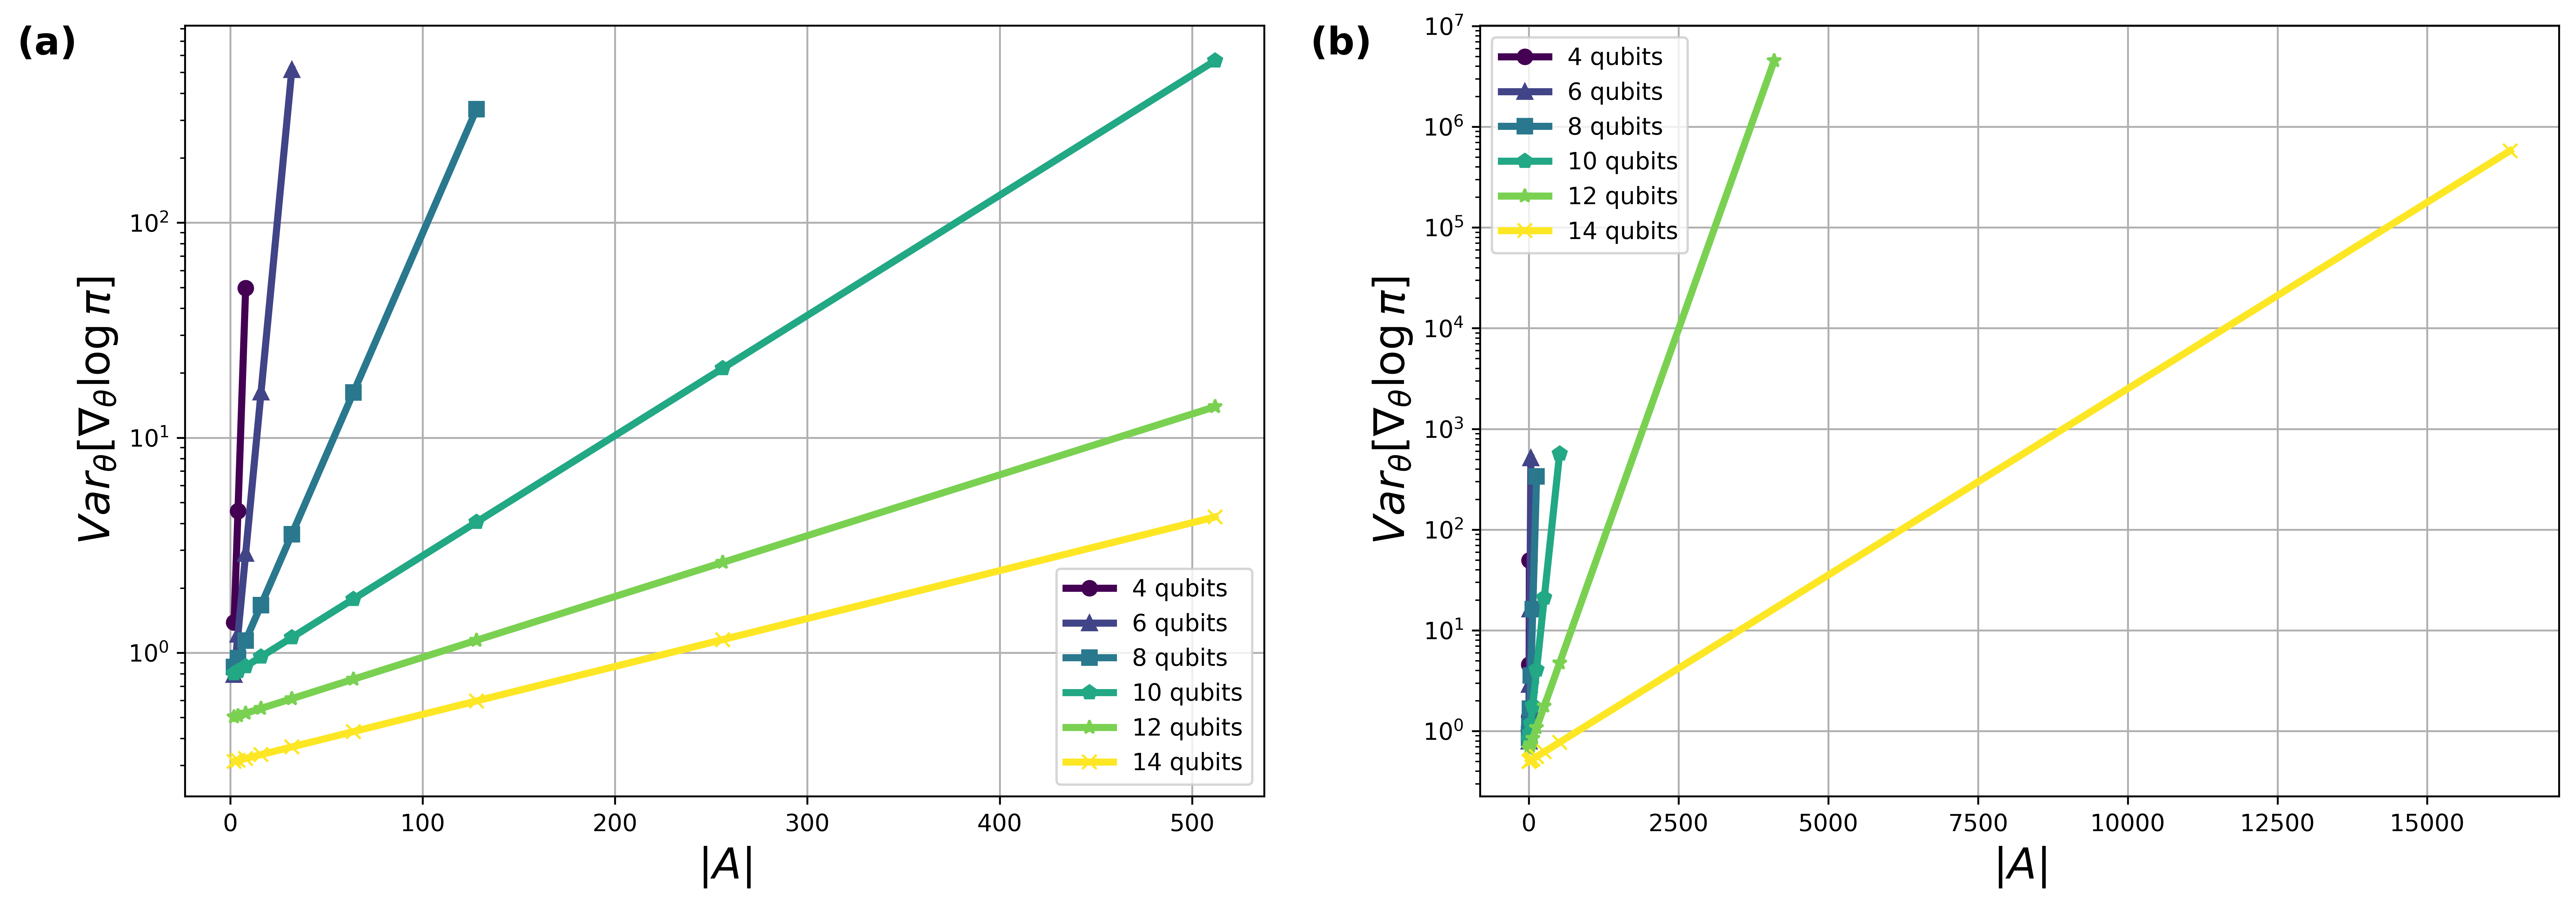

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

var_gradients_qubits = np.load("var_gradients_contiguous_clamp_f(A).npy",allow_pickle=True)
var_gradients_no_c = np.load("var_gradients_contiguous_no_clamp_f(A).npy",allow_pickle=True)

var_gradients_no_clamp = []
for i in range(len(var_gradients_no_c)):
    var_gradients_no_clamp.append(var_gradients_no_c[i])

gradients_n = []
for i in range(len(var_gradients_no_c)):
    gradients_n.append(var_gradients_no_c[i][0])

plt.rcParams['figure.dpi'] = 600
# ... [Your previous code, including the calculation of var_gradients_qubits] ...

# Define a list of markers
markers = ['o', '^', 's', 'p', '*', 'x', '+', 'D']

# Define a colormap
num_qubits = len(qubits)
colors = cm.viridis(np.linspace(0, 1, num_qubits))

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Adjust the figsize as needed

c=0
# Loop to create the same plot in each subplot

for i, n_qubits in enumerate(qubits):
    if n_qubits <= 10:
        actions = [2**j for j in range(1, n_qubits)]
        actions_ = actions
    else:
        actions = [2**j for j in range(1, 10)]
        actions_ = [2**j for j in range(1, 10)] + [2**n_qubits]

    # Select color and marker
    color = colors[i]
    marker = markers[i % len(markers)]
    
    #axes[0].plot(actions, var_gradients_no_clamp[i][:len(actions)], label=f"{n_qubits} qubits", marker=marker, color=color)
    p = np.polyfit(actions, np.log(var_gradients_no_clamp[i][:len(actions)]), 1)
    axes[0].semilogy(actions, np.exp(p[0] * np.array(actions) + p[1]), label=f"{n_qubits} qubits", marker=marker, color=color, linewidth=3.0)
   # Set common labels and title
    axes[0].set_xlabel(r"$|A|$",fontsize=18)
    axes[0].set_ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)
    axes[0].legend()
    axes[0].grid(visible=True)

    p = np.polyfit(actions_, np.log(var_gradients_no_clamp[i][:len(actions_)]), 1)
    axes[1].semilogy(actions_, np.exp(p[0] * np.array(actions_) + p[1]), label=f"{n_qubits} qubits", marker=marker, color=color, linewidth=3.0)
    #axes[1].plot(actions_, var_gradients_no_clamp[i][:len(actions_)], label=f"{n_qubits} qubits", marker=marker, color=color)
    
    axes[1].set_xlabel(r"$|A|$",fontsize=18)
    axes[1].set_ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)
    axes[1].legend()
    axes[1].grid(visible=True)


    #ax.axvspan(0, 60, color='grey', alpha=0.05, zorder=1)

#axes[1].plot(qubits, var_gradients_no_clamp, label=f"{n_qubits} qubits", marker=marker, color=color)
a=[]
#gradients_n = dict(np.load("gradients_parity-like_A=2_S2d.npy",allow_pickle=True).item())
qubits = [4,6,8,10,12,14]
#for q in qubits:
    #a.append(gradients_n[q])

policy_n = np.load("policy_parity-like_A=2_S2d.npy",allow_pickle=True)
'''
#axes[2].plot(qubits, a,marker="o",color="darkblue",alpha=0.3)
axes[2].plot(qubits, policy_n,marker="*",color="purple",alpha=0.3)
p = np.polyfit(qubits, np.log(gradients_n), 1)
axes[2].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"policy gradient", color="darkblue")
p = np.polyfit(qubits, np.log(policy_n), 1)
axes[2].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"policy", color="purple")
axes[2].axhline(y=0.5, color='darkorange', linestyle='-',label=r"$\pi=0.5$",alpha=0.5)
#insert text block top right corner with border 
axes[2].text(0.855, 0.72, r"$|A|=2$", fontsize=12, transform=plt.gcf().transFigure,bbox=dict(facecolor='white', alpha=0.5))
axes[2].text(-24.0, 0.7, r"(a)", fontsize=15, weight="bold")
axes[2].text(-11.0, 0.7, r"(b)", fontsize=15, weight="bold")
axes[2].text(2.5, 0.7, r"(c)", fontsize=15, weight="bold")

axes[2].set_xlabel("#Qubits",fontsize=18)
#axes[2].set_ylabel("PG variance / policy",fontsize=18)
axes[2].grid(visible=True,which="both")
axes[2].legend()
'''
#axes[1].set_ylabel(r"$Var_\theta [\nabla_\theta log \pi]$")

#plt.suptitle("Variance as a function of $|A|$")

# Set the legend for the first plot (or both if needed)

axes[0].text(-0.1, 1.0, '(a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Set label (b) at the top of the second subplot, adjust the coordinates as necessary
axes[1].text(-0.1, 1.0, '(b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.show()


### Parity-like Born policy - base case $|A|=2$ 
##### policy and gradients as a function of the number of qubits 

In [55]:
qubits = [4,6,8,10,12,14]
n_layers = 5
n_samples = 1000


gradients_n = {}
policy_n = []

for n_qubits in qubits:
    gradients_actions = []
    policy_actions = []

    print("-Starting with {} qubits".format(n_qubits))

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    #actions = [2**i for i in range(1,n_qubits)]
    actions = [2**n_qubits]
    
    for n_actions in actions:
        print("---Starting with ",n_actions," actions")
        gradients = []
        policy = []
        #fim_eigvals = []
        for s in range(n_samples):
            p=0
            weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]
            weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
            weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
            #param=torch.rand(1,requires_grad=True)  
            qc = create_circuit(n_qubits,circ="simplified_two_design",fim=False)
            #qc = create_circuit(n_qubits,circ="ghz")
            measure_qubits = n_qubits#int(np.log2(n_actions))    
            probs = qc(weights_tensor_init, weights_tensor_params, measurement_qubits=measure_qubits)
            #probs = qc(param, measurement_qubits=measure_qubits)[0]
            #policy = torch.sum(probs[:int((2**n_qubits)/n_actions)])
            #fim = FIM(probs, weights_tensor_params)
            #fim = qml.qinfo.classical_fisher(qc)(weights[0], weights[1], measurement_qubits=measure_qubits)[1]
            #fim_eigvals.append(np.linalg.eigvals(fim))


            #index = np.random.randint(2**measure_qubits)
            #policy = probs[-1]
            #gradients_no_clamp.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))

            #poly(n_qubits) clipping the policy
            #policy = torch.clamp(policy,0.1,1)
            for i in range(2**measure_qubits):
                if np.binary_repr(i,width=measure_qubits).count("1") % 2 == 0:
                    p+=probs[i] 
            #gradients.append(torch.sum(probs[:int((2**n_qubits)/2)]))
            #gradients.append(p)
            gradients.append(np.linalg.norm(compute_gradient(torch.log(p), weights_tensor_params),2))
            policy.append(p.detach().numpy())
        #var_gradients_actions.append(np.var(gradients))
        #var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))
        gradients_actions.append(np.var(gradients))
        policy_actions.append(np.mean(policy))
    #var_gradients_qubits.append(var_gradients_actions)
    gradients_n[n_qubits] = gradients_actions
    policy_n.append(policy_actions)

-Starting with 4 qubits
---Starting with  16  actions
-Starting with 6 qubits
---Starting with  64  actions
-Starting with 8 qubits
---Starting with  256  actions
-Starting with 10 qubits
---Starting with  1024  actions
-Starting with 12 qubits
---Starting with  4096  actions
-Starting with 14 qubits
---Starting with  16384  actions


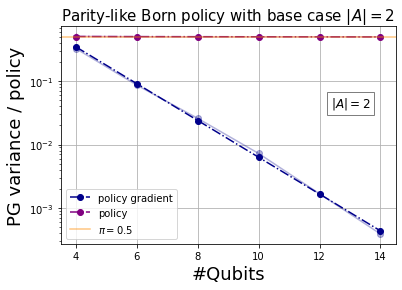

In [81]:
a=[]
for q in qubits:
    #plt.plot(fim_eigenvalues[q], label=f"{q} qubits")
    a.append(gradients_n[q])

plt.plot(qubits, a,marker="o",color="darkblue",alpha=0.3)
plt.plot(qubits, policy_n,marker="*",color="purple",alpha=0.3)
p = np.polyfit(qubits, np.log(a), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"policy gradient", color="darkblue")
p = np.polyfit(qubits, np.log(policy_n), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"policy", color="purple")
plt.axhline(y=0.5, color='darkorange', linestyle='-',label=r"$\pi=0.5$",alpha=0.5)
#insert text block top right corner with border 
plt.text(0.75, 0.6, r"$|A|=2$", fontsize=12, transform=plt.gcf().transFigure,bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel("#Qubits",fontsize=18)
plt.ylabel("PG variance / policy",fontsize=18)
plt.title("Parity-like Born policy with base case $|A|=2$",fontsize=15)
plt.grid()

plt.legend()

In [82]:
np.save("gradients_parity-like_A=2_S2d.npy",gradients_n)
np.save("policy_parity-like_A=2_S2d.npy",policy_n)

In [99]:
gradients_n = np.load("gradients_parity-like_A=2_S2d.npy",allow_pickle=True)
policy_n = np.load("policy_parity-like_A=2_S2d.npy",allow_pickle=True)
print(gradients_n)

{4: [0.324968949844204], 6: [0.08646626877494824], 8: [0.025852156891841716], 10: [0.007239858247980248], 12: [0.0016796090722983506], 14: [0.00039074988528797484]}


### Parity-like Born policy as a function of $|A|$

In [178]:
qubits = [4,6,8,10,12,14]
n_layers = 5
n_samples = 1000


var_gradients_qubits = []
var_gradients_no_clamp = []

for n_qubits in qubits:
    var_gradients_actions = []
    var_gradients_actions_no_clamp = []
    print("-Starting with {} qubits".format(n_qubits))

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    #actions = [2**i for i in range(1,n_qubits)]
    actions = {}
    for q in qubits:
        if q <= 10:
            actions[q] = [2**i for i in range(1,q)]
        else:
            actions[q] = [2**i for i in range(1, 10)] + [2**q]

    for n_actions in actions[n_qubits]:
        print("---Starting with ",n_actions," actions")
        gradients = []
        gradients_no_clamp = []
        for s in range(n_samples):
        
            weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]
            weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
            weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
            #param=torch.rand(1,requires_grad=True)  
            qc = create_circuit(n_qubits,circ="simplified_two_design",fim=False)
            #qc = create_circuit(n_qubits,circ="ghz")
            measure_qubits = n_qubits
            probs = qc(weights_tensor_init, weights_tensor_params, measurement_qubits=measure_qubits)
            m = int(np.log2(n_actions))
            policy=0
        
            for p in range(2**measure_qubits):
                ands = 1
                for i in range(m):
                    ands &= (np.binary_repr(p,width=measure_qubits)[:(n_qubits-i)].count("1") % 2 == 1)
                if ands:
                    policy+=probs[p] 
            
            #policy = torch.clamp(policy,0.1,1)

            gradients_no_clamp.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))

            #poly(n_qubits) clipping the policy
            #policy = torch.clamp(policy,0.1,1)
            #gradients.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))
        
        #var_gradients_actions.append(np.var(gradients))
        var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))
    #var_gradients_qubits.append(var_gradients_actions)
    var_gradients_no_clamp.append(var_gradients_actions_no_clamp)


-Starting with 4 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
-Starting with 6 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
---Starting with  16  actions
---Starting with  32  actions
-Starting with 8 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
---Starting with  16  actions
---Starting with  32  actions
---Starting with  64  actions
---Starting with  128  actions
-Starting with 10 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
---Starting with  16  actions
---Starting with  32  actions
---Starting with  64  actions
---Starting with  128  actions
---Starting with  256  actions
---Starting with  512  actions
-Starting with 12 qubits
---Starting with  2  actions
---Starting with  4  actions
---Starting with  8  actions
---Starting with  16  actions
---Starting with  32  actions
---Starting with  6

In [179]:
#np.save("var_gradients_parity-like_f(A)_S2d.npy",var_gradients_no_clamp)
#np.save("var_gradients_parity-like_f(A)_clamp_S2d.npy",var_gradients_no_clamp)

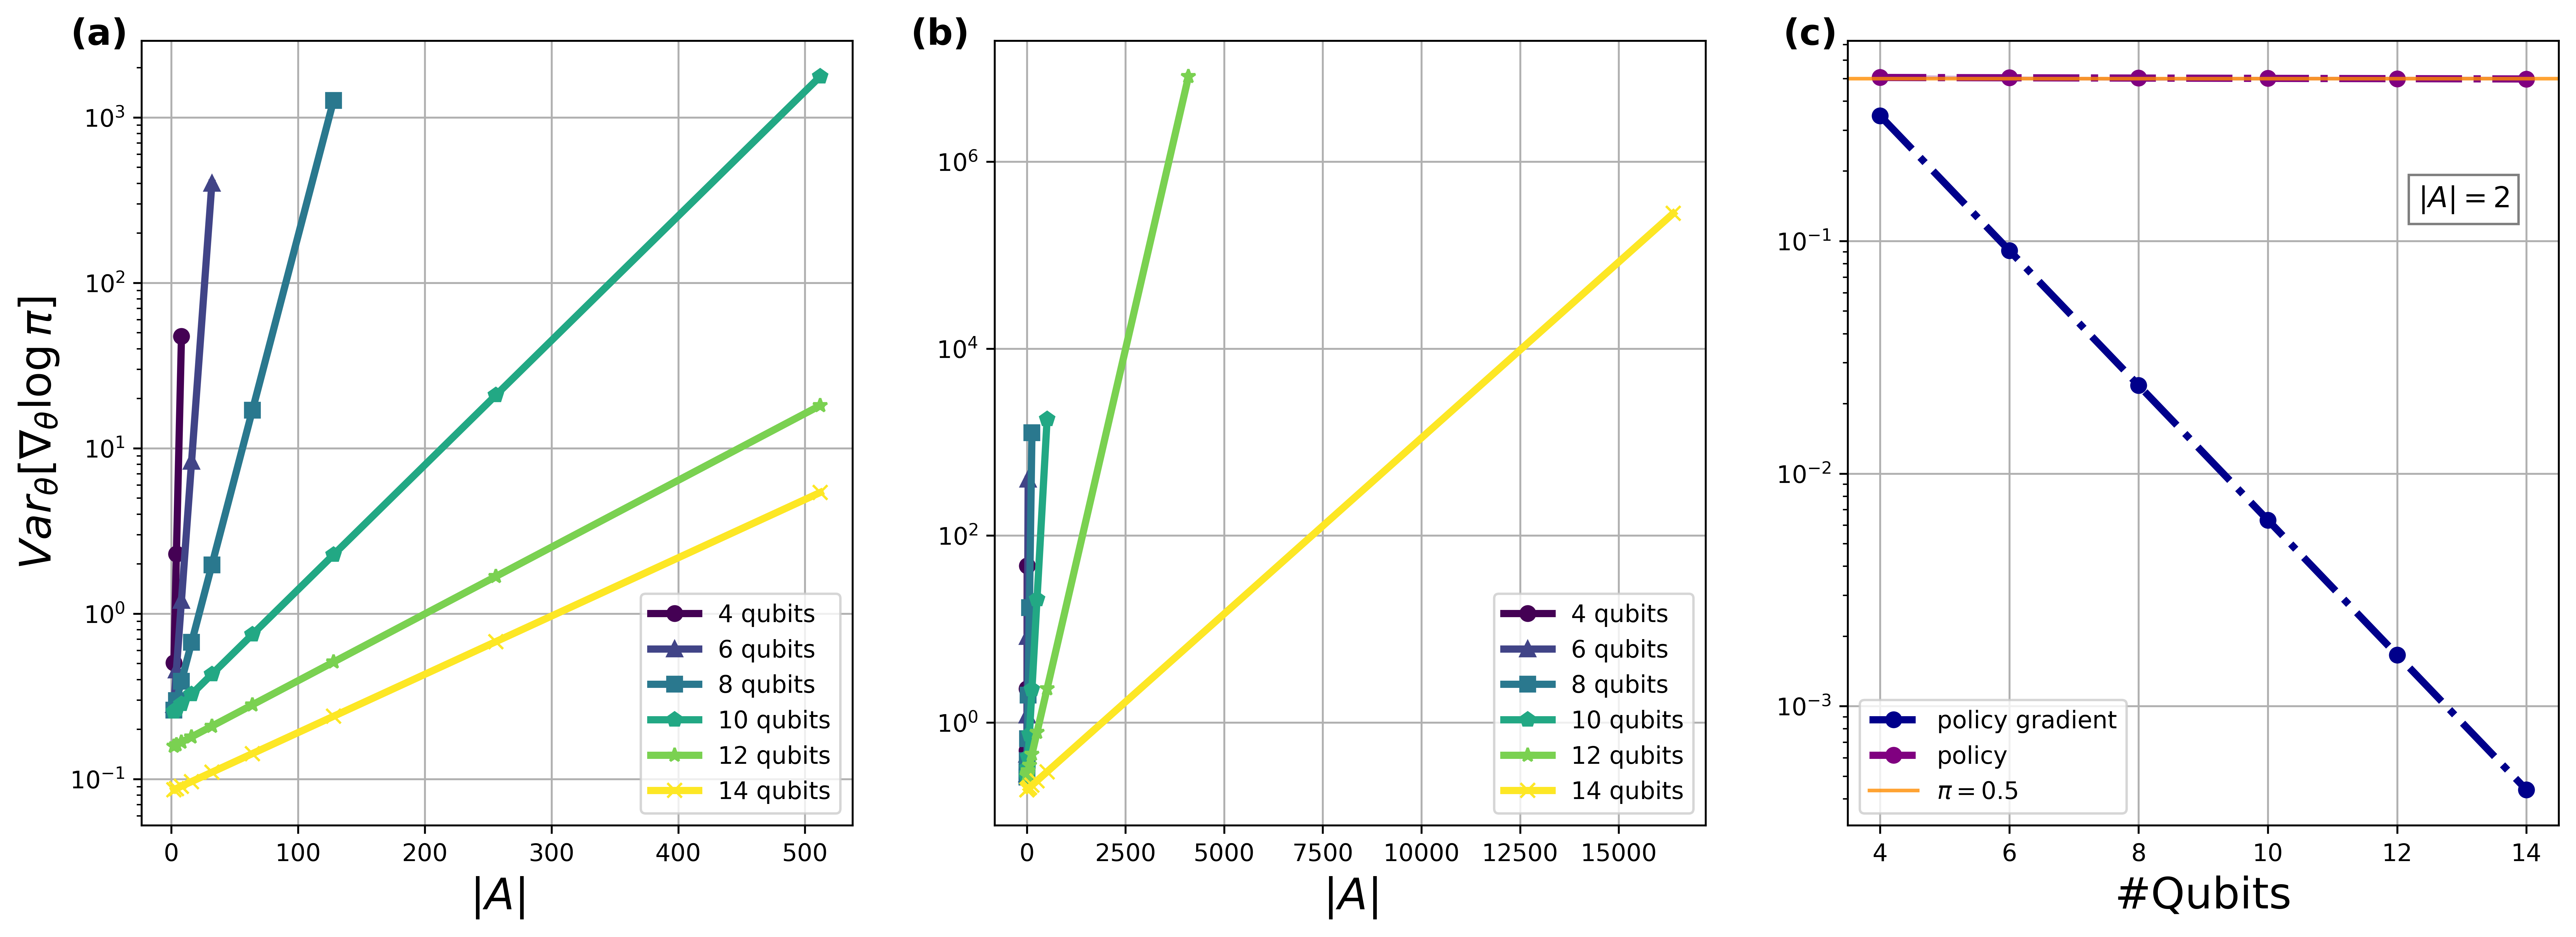

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

var_gradients_no_clamp = np.load("var_gradients_parity-like_f(A)_S2d.npy",allow_pickle=True)

plt.rcParams['figure.dpi'] = 600
# ... [Your previous code, including the calculation of var_gradients_qubits] ...

# Define a list of markers
markers = ['o', '^', 's', 'p', '*', 'x', '+', 'D']

# Define a colormap
num_qubits = len(qubits)
colors = cm.viridis(np.linspace(0, 1, num_qubits))

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the figsize as needed

c=0
# Loop to create the same plot in each subplot

for i, n_qubits in enumerate(qubits):
    if n_qubits <= 10:
        actions = [2**j for j in range(1, n_qubits)]
        actions_ = actions
    else:
        actions = [2**j for j in range(1, 10)]
        actions_ = [2**j for j in range(1, 10)] + [2**n_qubits]

    # Select color and marker
    color = colors[i]
    marker = markers[i % len(markers)]
    
    #axes[0].plot(actions, var_gradients_no_clamp[i][:len(actions)], label=f"{n_qubits} qubits", marker=marker, color=color)
    p = np.polyfit(actions, np.log(var_gradients_no_clamp[i][:len(actions)]), 1)
    axes[0].semilogy(actions, np.exp(p[0] * np.array(actions) + p[1]), label=f"{n_qubits} qubits", marker=marker, color=color, linewidth=3.0)
   # Set common labels and title
    axes[0].set_xlabel(r"$|A|$",fontsize=18)
    axes[0].set_ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)
    axes[0].legend()
    axes[0].grid(visible=True)

    p = np.polyfit(actions_, np.log(var_gradients_no_clamp[i][:len(actions_)]), 1)
    axes[1].semilogy(actions_, np.exp(p[0] * np.array(actions_) + p[1]), label=f"{n_qubits} qubits", marker=marker, color=color, linewidth=3.0)
    #axes[1].plot(actions_, var_gradients_no_clamp[i][:len(actions_)], label=f"{n_qubits} qubits", marker=marker, color=color)
    
    axes[1].set_xlabel(r"$|A|$",fontsize=18)
    #axes[1].set_ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)
    axes[1].legend()
    axes[1].grid(visible=True)


    #ax.axvspan(0, 60, color='grey', alpha=0.05, zorder=1)

#axes[1].plot(qubits, var_gradients_no_clamp, label=f"{n_qubits} qubits", marker=marker, color=color)
a=[]
gradients_n = dict(np.load("gradients_parity-like_A=2_S2d.npy",allow_pickle=True).item())
qubits = [4,6,8,10,12,14]
for q in qubits:
    a.append(gradients_n[q])

policy_n = np.load("policy_parity-like_A=2_S2d.npy",allow_pickle=True)

#axes[2].plot(qubits, a,marker="o",color="darkblue",alpha=0.3)
axes[2].plot(qubits, policy_n,marker="*",color="purple",alpha=0.3)
p = np.polyfit(qubits, np.log(a), 1)
axes[2].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"policy gradient", color="darkblue", linewidth=3.0)
p = np.polyfit(qubits, np.log(policy_n), 1)
axes[2].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"policy", color="purple", linewidth=3.0)
axes[2].axhline(y=0.5, color='darkorange', linestyle='-',label=r"$\pi=0.5$",alpha=0.8)
#insert text block top right corner with border 
axes[2].text(0.855, 0.72, r"$|A|=2$", fontsize=12, transform=plt.gcf().transFigure,bbox=dict(facecolor='white', alpha=0.5))
axes[2].text(-24.0, 0.7, r"(a)", fontsize=15, weight="bold")
axes[2].text(-11.0, 0.7, r"(b)", fontsize=15, weight="bold")
axes[2].text(2.5, 0.7, r"(c)", fontsize=15, weight="bold")

axes[2].set_xlabel("#Qubits",fontsize=18)
#axes[2].set_ylabel("PG variance / policy",fontsize=18)
axes[2].grid(visible=True)
axes[2].legend()

#axes[1].set_ylabel(r"$Var_\theta [\nabla_\theta log \pi]$")

#plt.suptitle("Variance as a function of $|A|$")

# Set the legend for the first plot (or both if needed)

plt.show()


### Parity-like Born policy as a function of $|A|$ (polynomial clipping probabilities)

In [6]:
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import os

from helper import compute_gradient_for_sample

# Main part of the code
qubits = [4,6,8,10,12,14]
n_layers = 5
n_samples = 2000

var_gradients_no_clamp = []
exp_gradients_no_clamp = []

for n_qubits in qubits:
    var_gradients_actions_no_clamp = []
    exp_gradients_actions_no_clamp = []
    print(f"-Starting with {n_qubits} qubits")

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    actions = {q: [2**i for i in range(1, n_qubits)] for q in qubits}

    for n_actions in actions[n_qubits]:
        print(f"---Starting with {n_actions} actions")
        gradients_no_clamp = []

        # Parallel processing
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
            future_to_gradient = {executor.submit(compute_gradient_for_sample, (n_qubits, shapes, "simplified_two_design", n_actions)): s for s in range(n_samples)}
            for future in concurrent.futures.as_completed(future_to_gradient):
                gradients_no_clamp.append(future.result())

        var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))
        exp_gradients_actions_no_clamp.append(np.mean(gradients_no_clamp))

    var_gradients_no_clamp.append(var_gradients_actions_no_clamp)
    exp_gradients_no_clamp.append(exp_gradients_actions_no_clamp)

# var_gradients_no_clamp now contains the results


-Starting with 4 qubits
---Starting with 2 actions
---Starting with 4 actions
---Starting with 8 actions
-Starting with 6 qubits
---Starting with 2 actions
---Starting with 4 actions
---Starting with 8 actions
---Starting with 16 actions
---Starting with 32 actions
-Starting with 8 qubits
---Starting with 2 actions
---Starting with 4 actions
---Starting with 8 actions
---Starting with 16 actions
---Starting with 32 actions
---Starting with 64 actions
---Starting with 128 actions
-Starting with 10 qubits
---Starting with 2 actions
---Starting with 4 actions
---Starting with 8 actions
---Starting with 16 actions
---Starting with 32 actions
---Starting with 64 actions
---Starting with 128 actions
---Starting with 256 actions
---Starting with 512 actions
-Starting with 12 qubits
---Starting with 2 actions
---Starting with 4 actions
---Starting with 8 actions


In [5]:
#np.save("var_gradients_parity-like_f(A)_clamp_S2d_.npy", var_gradients_no_clamp)
np.save("var_gradients_parity-like_f(A)_clamp_S2d_new.npy", var_gradients_no_clamp)
np.save("exp_gradients_parity-like_f(A)_clamp_S2d_new.npy", var_gradients_no_clamp)

/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [211]:
np.save("var_gradients_parity-like_|A|=2^n_S2d.npy",var_gradients_no_clamp)

[[0.08035316]
 [0.00660261]
 [0.00010327]
 [0.        ]
 [0.        ]
 [0.        ]]


/var/folders/n9/tdqdt7991733xw39nzh49y600000gn/T/ipykernel_17135/2557461886.py:75: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(actions, np.log(var_gradients_no_clamp[i][:len(actions)]), 1)
/var/folders/n9/tdqdt7991733xw39nzh49y600000gn/T/ipykernel_17135/2557461886.py:101: RuntimeWarning: divide by zero encountered in log
  coefficients = np.polyfit(qubits, np.log(n3_actions), 1)


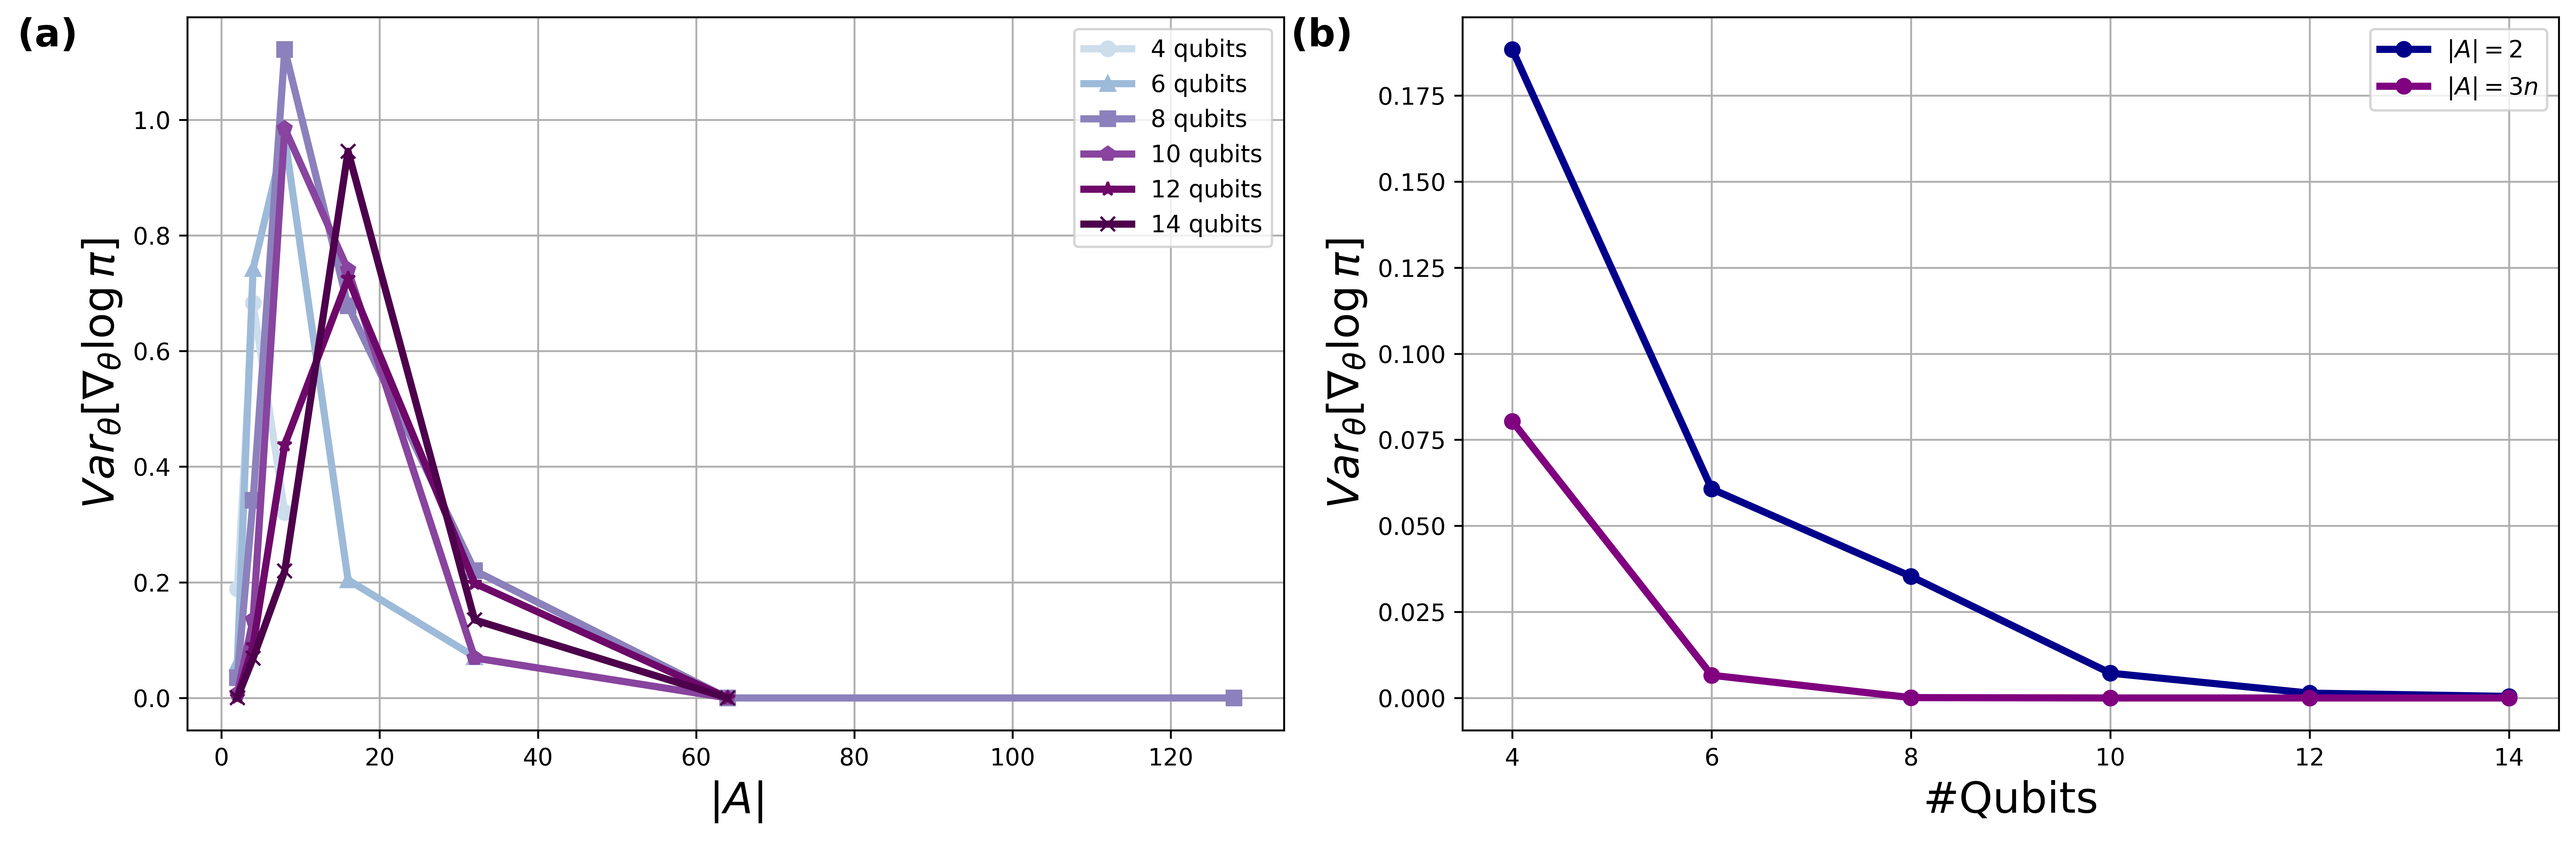

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

var_gradients_no_clamp = np.load("var_gradients_parity-like_f(A)_clamp_S2d_.npy",allow_pickle=True)
var_gradients_3n = np.load("var_gradients_parity-like_f(A)_S2d_3n.npy",allow_pickle=True)
print(var_gradients_3n)
a = np.load("var_gradients_parity-like_|A|=2^n_S2d.npy",allow_pickle=True)
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
# ... [Your previous code, including the calculation of var_gradients_qubits] ...

# Define a list of markers
markers = ['o', '^', 's', 'p', '*', 'x', '+', 'D']

# Define a colormap
qubits = [4,6,8,10,12,14]

num_qubits = len(qubits)
colors = cm.BuPu(np.linspace(0.2,1.1,num_qubits))

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize as needed

poly = []
polylog = []
outside_poly_n_outcomes = []
for i in range(len(qubits)):
    n_qubits = qubits[i]    
    #if n_qubits < 10:
    actions = [2**j for j in range(1, n_qubits)]
    #else:
    #actions = [2**j for j in range(1, 10)]
    not_complete = True
    j=0
    while not_complete:
    #for j in range(len(actions)):
        if n_qubits == 4 or n_qubits == 6:
            stop = 8
        else:
            stop = 16
        if actions[j] == stop:
            #poly.append(var_gradients_no_clamp[i][j-2])
            polylog.append(var_gradients_no_clamp[i][j])
            #outside_poly_n_outcomes.append(var_gradients_no_clamp[i][j])
            #break
            not_complete = False
        else:
            j+=1
        
    poly.append(var_gradients_no_clamp[i][0])


#outside_poly_n_outcomes = a
n3_actions = []
for i in range(len(qubits)):
    outside_poly_n_outcomes.append(var_gradients_no_clamp[i][-1])
    n3_actions.append(var_gradients_3n[i][0])
c=0
# Loop to create the same plot in each subplot

for i, n_qubits in enumerate(qubits):
    if n_qubits < 10:
        actions = [2**j for j in range(1, n_qubits)]
        actions_ = actions
    else:
        actions = [2**j for j in range(1, 8)][:-1]
        actions_ = [2**j for j in range(1, 8)][:-1] #+ [2**n_qubits]

    # Select color and marker
    color = colors[i]
    marker = markers[i % len(markers)]
    
    axes[0].plot(actions, var_gradients_no_clamp[i][:len(actions)], label=f"{n_qubits} qubits", marker=marker, color=color, linewidth=3)
    p = np.polyfit(actions, np.log(var_gradients_no_clamp[i][:len(actions)]), 1)
    #axes[0].semilogy(actions, np.exp(p[0] * np.array(actions) + p[1]), label=f"{n_qubits} qubits", marker=marker, color=color)
   # Set common labels and title
    axes[0].set_xlabel(r"$|A|$",fontsize=18)
    axes[0].set_ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)
    axes[0].legend()
    axes[0].grid(visible=True,which="both")


#inset_ax = axes[0].inset_axes([0.5, 0.2, 0.4, 0.4])  # Inset axes [left, bottom, width, height]
axes[1].plot(qubits,poly, marker='o', color='darkblue', label=r"$|A|=2$", linewidth=3)
#polynomial fitting to octopipers
#coefficients = np.polyfit(qubits, poly, 1)
coefficients = np.polyfit(qubits, np.log(poly), 1)
polynomial = np.poly1d(coefficients)

# Generate y values using the polynomial for plotting
y_fit = polynomial(qubits)
#inset_ax.plot(qubits,y_fit, marker='o', color='darkblue',label=r"$|A|<n$",alpha=0.8)
#axes[1].semilogy(qubits, np.exp(coefficients[0] * np.array(qubits) + coefficients[1]), "o-", label=r"$|A|=2$", color="darkblue", linewidth=3)


###
axes[1].plot(qubits,n3_actions, marker='o', color='purple',alpha=1.0, label=r"$|A| = 3n$", linewidth=3)
#polynomial fitting to octopipers
#coefficients = np.polyfit(qubits, poly, 1)
coefficients = np.polyfit(qubits, np.log(n3_actions), 1)
polynomial = np.poly1d(coefficients)

# Generate y values using the polynomial for plotting
y_fit = polynomial(qubits)
#inset_ax.plot(qubits,y_fit, marker='o', color='darkblue',label=r"$|A|<n$",alpha=0.8)
#axes[1].semilogy(qubits, np.exp(coefficients[0] * np.array(qubits) + coefficients[1]), "o-", label=r"$|A| = 3n$", color="darkcyan", linewidth=3)


#axes[1].plot(qubits,polylog, marker='*', color='purple',alpha=0.3)
#polynomial fitting to octopipers
#p = np.polyfit(qubits, octopipers, 4)
#inset_ax.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", color="darkorange")
coefficients = np.polyfit(qubits, polylog, 2)
polynomial = np.poly1d(coefficients)

# Generate y values using the polynomial for plotting
y_fit = polynomial(qubits)
#axes[1].plot(qubits,y_fit, marker='*', color='purple',label=r"$n<|A|<poly(n)$",linewidth=3)
#set x-axis ticks
#axes[1].plot(qubits,np.log(outside_poly_n_outcomes), marker='s', color='cyan',alpha=1.0, linewidth=3.0)
#p = np.polyfit(qubits, np.log(outside_poly_n_outcomes), 1)
#axes[1].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "s-", label=r"$|A| = 2^n$", color="cyan", linewidth=3)

axes[1].set_xticks(qubits)
axes[1].set_xlabel(r"#Qubits",fontsize=10)
axes[1].set_ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)
axes[1].legend()
   
#axes[1].plot(qubits, var_gradients_no_clamp, label=f"{n_qubits} qubits", marker=marker, color=color)
gradients_n = dict(np.load("gradients_parity-like_A=2_S2d.npy",allow_pickle=True).item())
qubits = [4,6,8,10,12,14]
#for q in qubits:
    #a.append(gradients_n[q])
#axes[1].plot(qubits, a,marker="o",color="darkblue",alpha=0.3)
#axes[1].plot(qubits, policy_n,marker="*",color="purple",alpha=0.3)
#vertical line in x=12
#p = np.polyfit(qubits, np.log(a), 1)
#axes[1].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"$|A|=2^n$", color="darkblue")
#p = np.polyfit(qubits, np.log(policy_n), 1)
#axes[1].semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"policy", color="purple")
#axes[1].axhline(y=0.5, color='darkorange', linestyle='-',label=r"$\pi=0.5$",alpha=0.5)
#insert text block top right corner with border 
#axes[1].text(0.855, 0.72, r"$|A|=2$", fontsize=12, transform=plt.gcf().transFigure,bbox=dict(facecolor='white', alpha=0.5))
#axes[1].text(-24.0, 0.7, r"(a)", fontsize=15, weight="bold")
# Set label (a) at the top of the first subplot, adjust the coordinates as necessary
axes[0].text(-0.1, 1.0, '(a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Set label (b) at the top of the second subplot, adjust the coordinates as necessary
axes[1].text(-0.1, 1.0, '(b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

axes[1].set_xlabel("#Qubits",fontsize=18)
#axes[1].set_ylabel("PG variance / policy",fontsize=18)
axes[1].grid(visible=True)
axes[1].legend()

#axes[1].set_ylabel(r"$Var_\theta [\nabla_\theta log \pi]$")

#plt.suptitle("Variance as a function of $|A|$")

# Set the legend for the first plot (or both if needed)
plt.tight_layout()
plt.show()


### Parallelization  

In [9]:
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import os

from helper import compute_gradient_for_sample

# Main part of the code
qubits = [4,6,8,10,12,14]
n_layers = 5
n_samples = 5000

var_gradients_no_clamp = []
exp_gradients_no_clamp = []

for n_qubits in qubits:
    var_gradients_actions_no_clamp = []
    exp_gradients_actions_no_clamp = []
    print(f"-Starting with {n_qubits} qubits")

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    actions = {}#q: [2**i for i in range(1, n_qubits)] for q in qubits}
    for q in qubits:
        actions[q] = [3*n_qubits]
    for n_actions in actions[n_qubits]:
        print(f"---Starting with {n_actions} actions")
        gradients_no_clamp = []

        # Parallel processing
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
            future_to_gradient = {executor.submit(compute_gradient_for_sample, (n_qubits, shapes, "simplified_two_design", n_actions)): s for s in range(n_samples)}
            for future in concurrent.futures.as_completed(future_to_gradient):
                gradients_no_clamp.append(future.result())

        var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))
        exp_gradients_actions_no_clamp.append(np.mean(gradients_no_clamp))

    var_gradients_no_clamp.append(var_gradients_actions_no_clamp)
    exp_gradients_no_clamp.append(exp_gradients_actions_no_clamp)

# var_gradients_no_clamp now contains the results


-Starting with 4 qubits
---Starting with 12 actions
-Starting with 6 qubits
---Starting with 18 actions
-Starting with 8 qubits
---Starting with 24 actions
-Starting with 10 qubits
---Starting with 30 actions
-Starting with 12 qubits
---Starting with 36 actions
-Starting with 14 qubits
---Starting with 42 actions


In [10]:
np.save("var_gradients_contiguous-like_f(A)_S2d_3n_.npy", var_gradients_no_clamp)
np.save("exp_gradients_contiguous-like_f(A)_S2d_3n_.npy", exp_gradients_no_clamp)

### RY product state 

In [53]:
qubits = [2,4,6,8,10,12,14,16]
n_layers = 5
n_samples = 10000


#var_gradients_qubits = []
var_gradients_no_log = []
var_gradients_log = []

for n_qubits in qubits:
    #var_gradients_actions_log= []
    #var_gradients_actions_no_log = []
    print("-Starting with {} qubits".format(n_qubits))

    #shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    actions = [2**n_qubits]
    
    for n_actions in actions:
        print("---Starting with ",n_actions," actions")
        #gradients = []
        gradients_no_log = []
        gradients_log = []
        for s in range(n_samples):
            
            weights = np.random.uniform(-np.pi,np.pi,size=n_qubits)
            #weights_tensor_params = (2*np.pi)*torch.rand(n_qubits,requires_grad=True) - np.pi
            weights_tensor_params = torch.tensor(weights,requires_grad=True)
            qc = create_circuit(n_qubits,circ="RY")
            measure_qubits = int(np.log2(n_actions))    
            probs = qc(weights_tensor_params, y=False, probs=True)
            policy = probs[-1]
            gradients_log.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))
            gradients_no_log.append(np.linalg.norm(compute_gradient(policy, weights_tensor_params),2))

            #poly(n_qubits) clipping the policy
            #policy = torch.clamp(policy,0.1,1)

            #gradients.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))
            #gradients.append(compute_gradient(torch.log(policy), param))
        
        #var_gradients_actions.append(np.var(gradients))
        var_gradients_no_log.append(np.var(gradients_no_log))
        var_gradients_log.append(np.var(gradients_log))
    #var_gradients_qubits.append(var_gradients_actions)
    #var_gradients_no_log.append(var_gradients_actions_no_clamp


-Starting with 2 qubits
---Starting with  4  actions
-Starting with 4 qubits
---Starting with  16  actions
-Starting with 6 qubits
---Starting with  64  actions
-Starting with 8 qubits
---Starting with  256  actions
-Starting with 10 qubits
---Starting with  1024  actions
-Starting with 12 qubits
---Starting with  4096  actions
-Starting with 14 qubits
---Starting with  16384  actions
-Starting with 16 qubits
---Starting with  65536  actions


Text(0, 0.5, '$Var_\\theta [\\nabla_\\theta \\log \\pi]$')

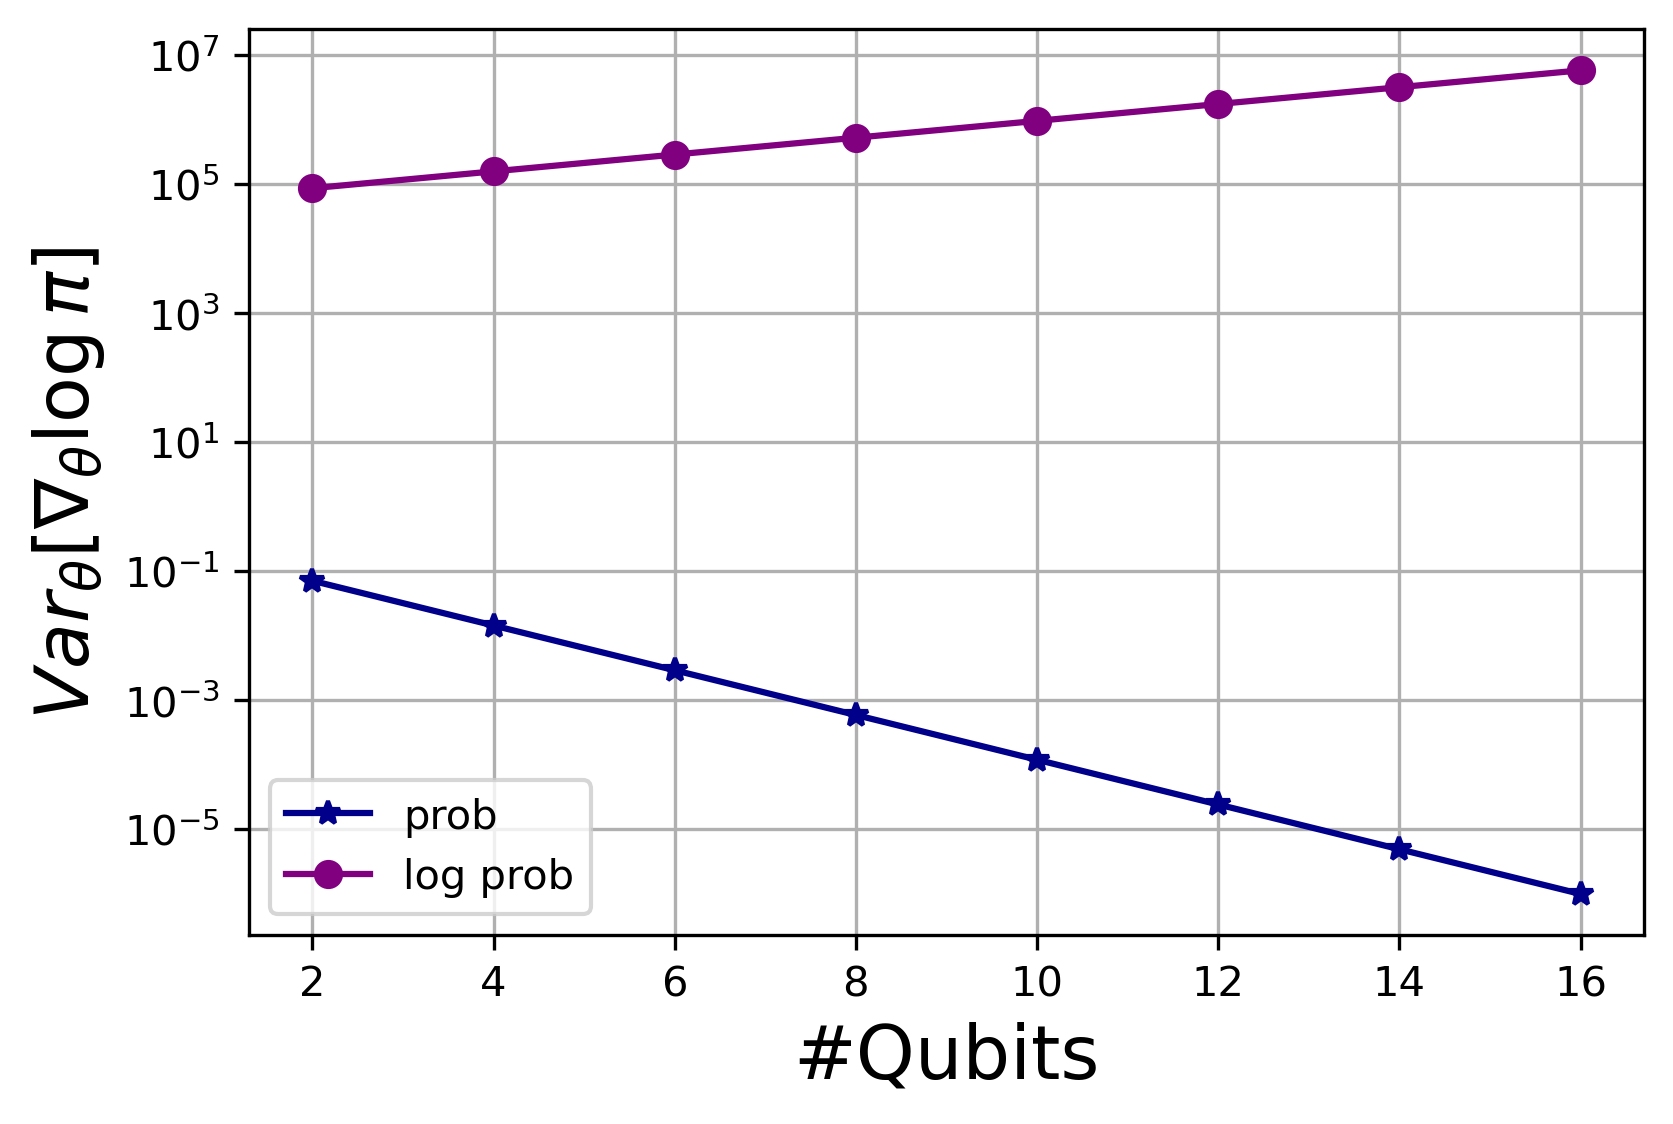

In [54]:
plt.rcParams['figure.dpi'] = 300
#plt.plot(qubits, var_gradients_no_log, label="prob",color="darkblue", marker="o")
#lt.plot(qubits, var_gradients_log, label="log prob", color="purple", marker="*")
p = np.polyfit(qubits, np.log(var_gradients_no_log), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "*-", label=f"prob", color="darkblue")
p = np.polyfit(qubits, np.log(var_gradients_log), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-", label=f"log prob", color="purple")

plt.legend()
plt.grid()
plt.xlabel(r"#Qubits",fontsize=18)
plt.ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)

### Classical Fisher Information eigenvalues as a function of |A| 

In [25]:
def FIM(outs,weights):
    num_params = len(weights.view(-1))
    fisher_info_matrix = np.zeros((num_params, num_params))
    #for s in range(n_samples):
    
    #outs = qcircuit_fisher(s,weights)

    for i in range(len(outs)):
        if weights.grad is not None:
            #print("grad not none")
            weights.grad.zero_()
        
        #outs = qcircuit_fisher(s,weights)
        log_prob = outs[i]

        log_prob.backward(retain_graph=True)
        grad = weights.grad.view(-1)
        grad_np = grad.detach().numpy()  # Detach the gradients and convert to NumPy
        fisher_info_matrix += (1/outs[i].detach().numpy()) * np.outer(grad_np, grad_np)
    #fisher_info_matrix /= n_samples

    regularization_constant = 0.1
    fisher_info_matrix += regularization_constant * np.eye(num_params)
    fisher_info_matrix = fisher_info_matrix.real

    return fisher_info_matrix

#### FIM eigenvalues for $|A|=2^n$

In [110]:
qubits = [4,6,8,10,12,14]
n_layers = 5
n_samples = 100


fim_eigenvalues = {}
fim_norm=[]

for n_qubits in qubits:
    fim_actions = []
    print("-Starting with {} qubits".format(n_qubits))

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    actions = [2**n_qubits]
    
    for n_actions in actions:
        print("---Starting with ",n_actions," actions")
        fim_eigvals = []
        for s in range(n_samples):
        
            weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]
            weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
            weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
            qc = create_circuit(n_qubits,circ="simplified_two_design",fim=True)
            measure_qubits = int(np.log2(n_actions))    
            probs = qc(weights_tensor_init, weights_tensor_params, measurement_qubits=measure_qubits)
            fim = FIM(probs, weights_tensor_params)
            fim_eigvals.append(np.linalg.eigvals(fim))
        fim_actions.append(np.mean(fim_eigvals,0))
    fim_eigenvalues[n_qubits] = fim_actions


-Starting with 4 qubits
---Starting with  16  actions


Process SpawnProcess-1:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/concurrent/futures/process.py", line 237, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'compute_sample_eigenvalues' on <module '__main__' (built-in)>


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [104]:
#np.save("fim_eigenvalues_parity-like_|A|=2^n_4-10.npy",fim_eigenvalues)
#np.save("fim_eigenvalues_parity-like_|A|=2^n.npy",fim_eigenvalues)
fim_eigvals = np.load("fim_eigenvalues_parity-like_|A|=2^n.npy",allow_pickle=True).item()
fim_eigvals[4] = fim_eigenvalues[4]
np.save("fim_eigenvalues_parity-like_|A|=2^n_.npy",fim_eigvals)
'''
fim_eigenvalues_12_14 = np.load("fim_eigenvalues_parity-like_|A|=2^n_12_14.npy",allow_pickle=True).item()
fim_eigenvalues_4_10 = np.load("fim_eigenvalues_parity-like_|A|=2^n_4-10.npy",allow_pickle=True).item()
merge_fim_eigenvalues = {}
qubits = [4,6,8,10]
for q in qubits:
    merge_fim_eigenvalues[q] = fim_eigenvalues_4_10[q]
merge_fim_eigenvalues[12] = fim_eigenvalues_12_14[12]
merge_fim_eigenvalues[14] = fim_eigenvalues_12_14[14]

np.save("fim_eigenvalues_parity-like_|A|=2^n_4-14.npy",merge_fim_eigenvalues)
'''

'\nfim_eigenvalues_12_14 = np.load("fim_eigenvalues_parity-like_|A|=2^n_12_14.npy",allow_pickle=True).item()\nfim_eigenvalues_4_10 = np.load("fim_eigenvalues_parity-like_|A|=2^n_4-10.npy",allow_pickle=True).item()\nmerge_fim_eigenvalues = {}\nqubits = [4,6,8,10]\nfor q in qubits:\n    merge_fim_eigenvalues[q] = fim_eigenvalues_4_10[q]\nmerge_fim_eigenvalues[12] = fim_eigenvalues_12_14[12]\nmerge_fim_eigenvalues[14] = fim_eigenvalues_12_14[14]\n\nnp.save("fim_eigenvalues_parity-like_|A|=2^n_4-14.npy",merge_fim_eigenvalues)\n'

In [17]:
qubits = [4,6,8,10,12,14]
trace_norms = []
for q in qubits:
    trace_norms.append(np.linalg.norm(fim_eigenvalues[q],2))


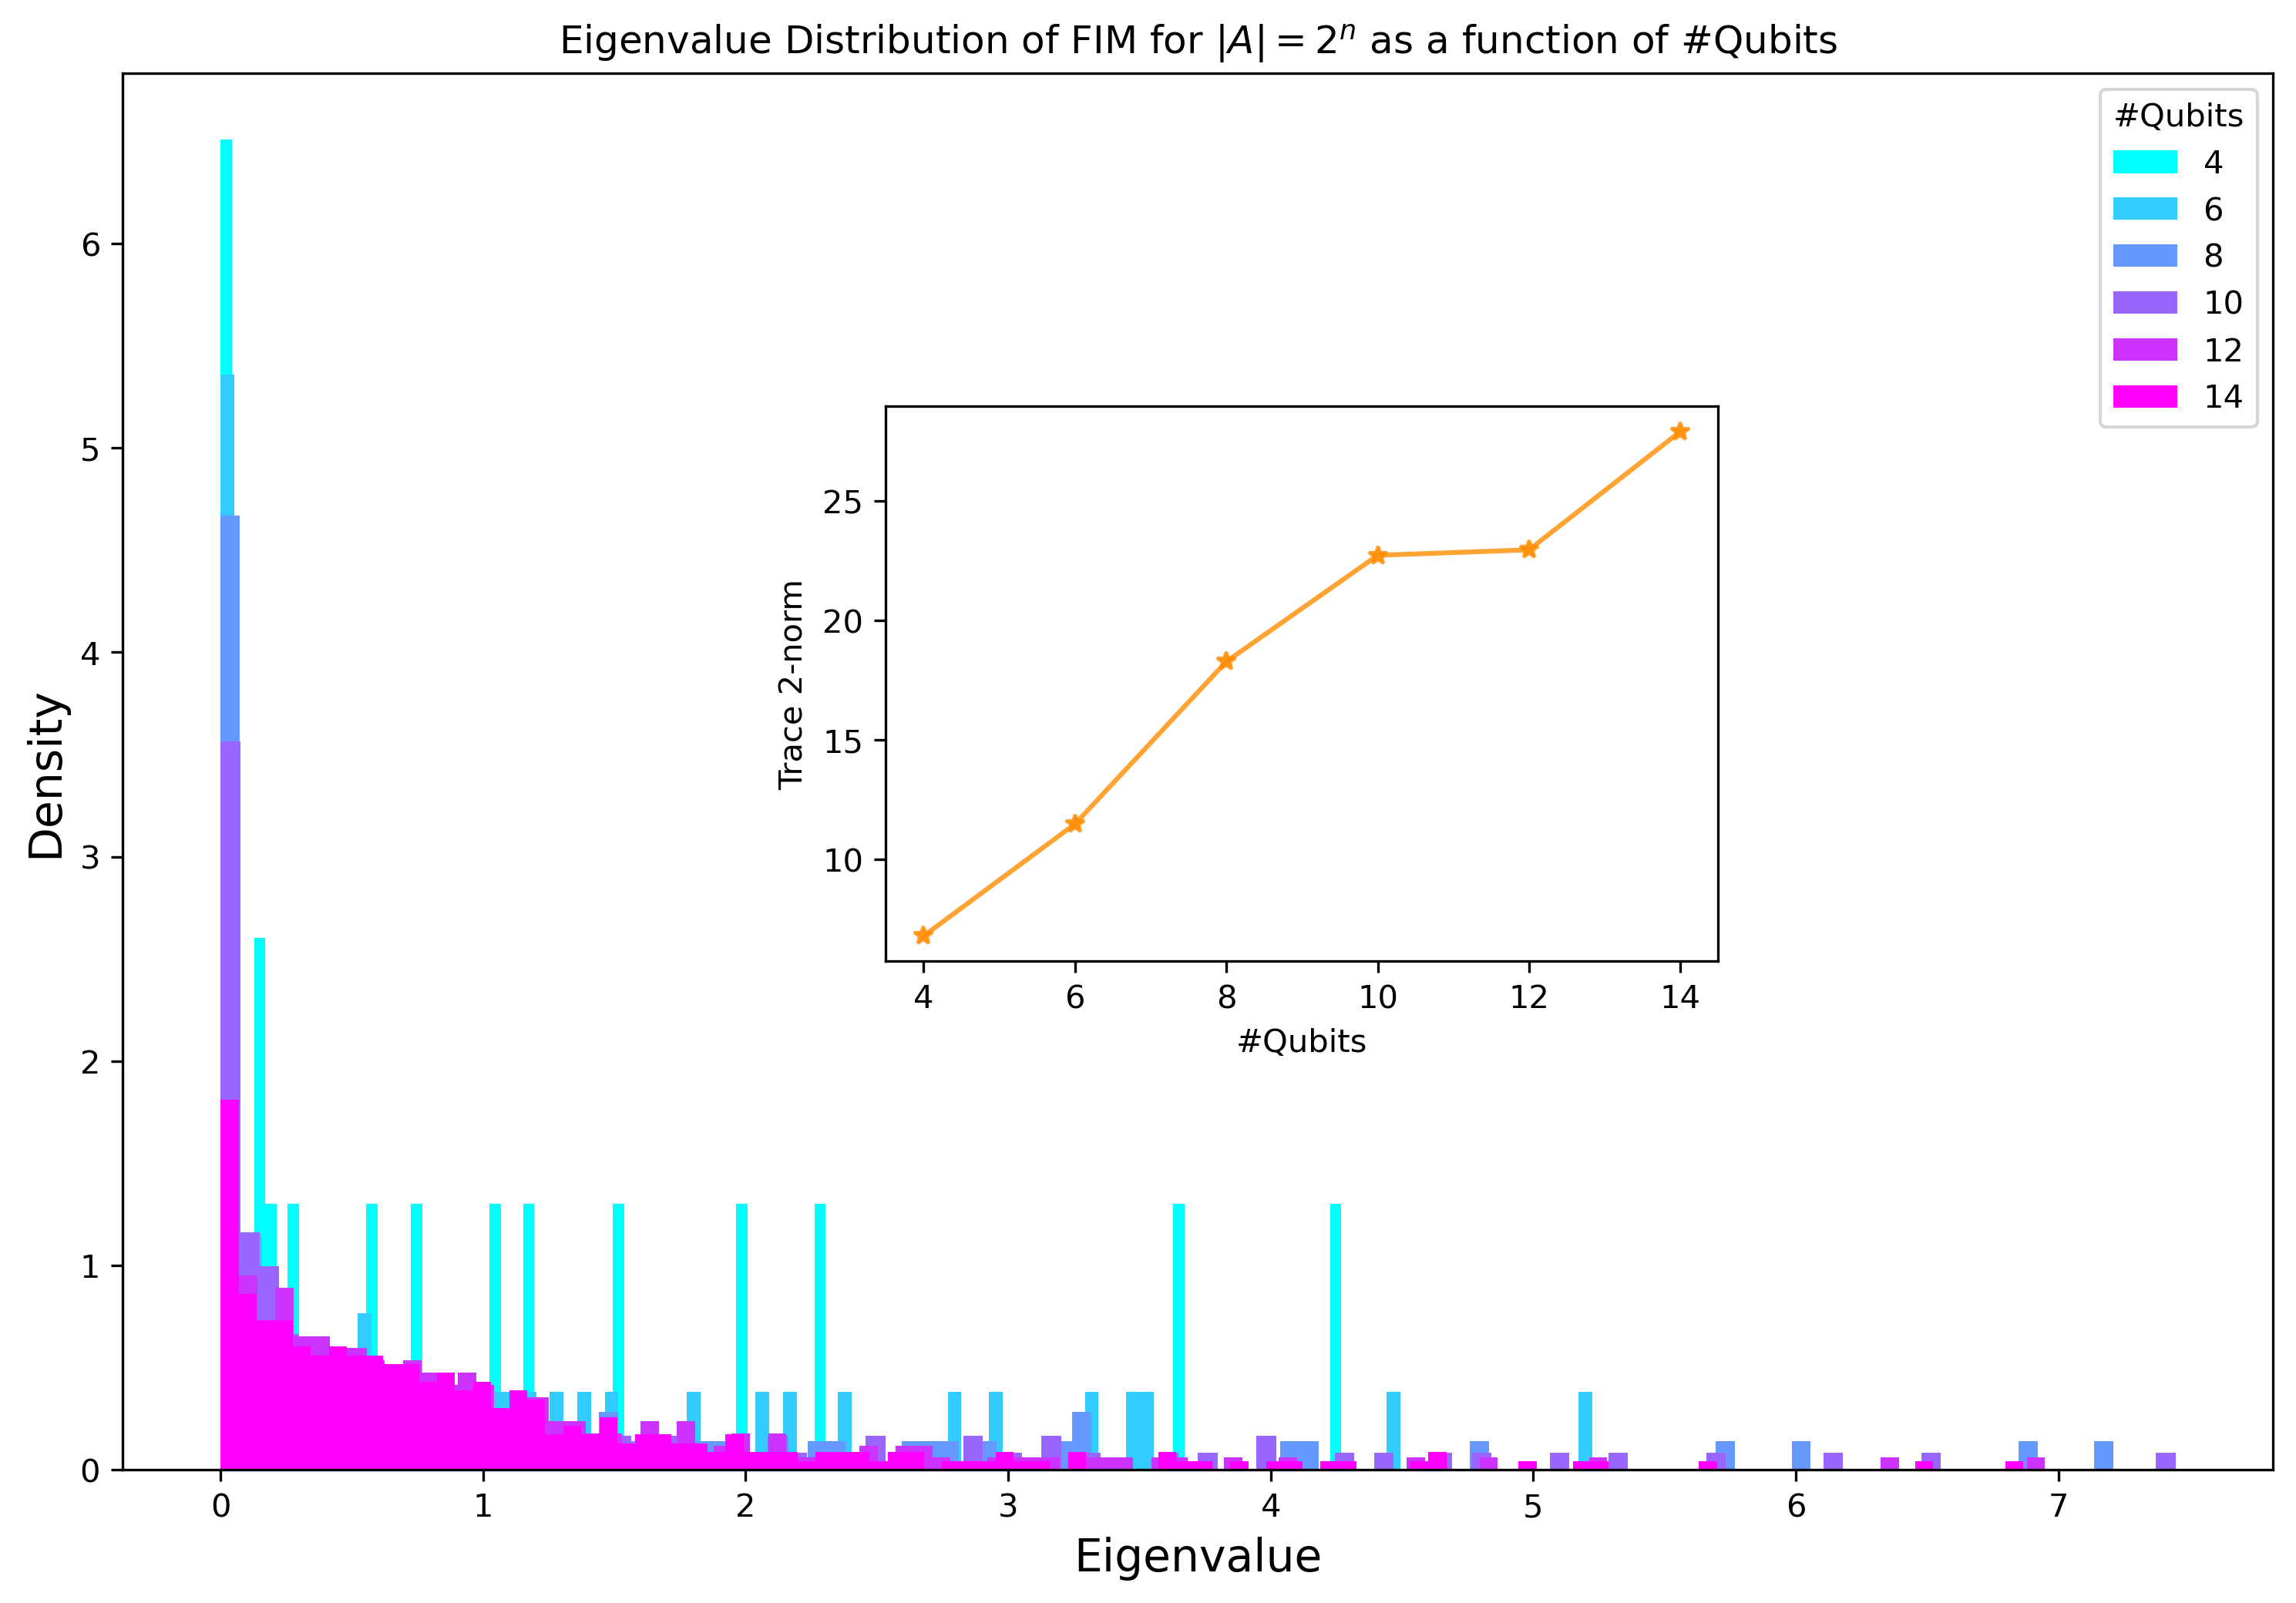

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# dpi 300
plt.rcParams['figure.dpi'] = 300

# Generate a colormap and create a color iterator
colormap = plt.cm.cool
color_iterator = iter(colormap(np.linspace(0, 1, len(fim_eigenvalues))))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each set of eigenvalues with its corresponding color
for num_qubits, eigenvalues in fim_eigenvalues.items():
    color = next(color_iterator)
    plt.hist(eigenvalues, bins=100, density=True, alpha=1.0, color=color, label=num_qubits)

plt.title('Eigenvalue Distribution of FIM for $|A|=2^n$ as a function of #Qubits')
plt.xlabel('Eigenvalue', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='#Qubits')

#inset axes for trace_norms
inset_ax = plt.axes([0.4, 0.4, 0.3, 0.3])  # Inset axes [left, bottom, width, height]
inset_ax.plot(qubits,trace_norms, marker='*', color='darkorange',label=r"trace norm",alpha=0.8)
#set x_label and y_label
inset_ax.set_xticks(qubits)
inset_ax.set_xlabel(r"#Qubits",fontsize=10)
inset_ax.set_ylabel(r"Trace 2-norm",fontsize=10)
plt.show()


### FIM eigenvalues for $|A|=2$

In [31]:
qubits = [4,6,8,10,12,14]
n_layers = 5
n_samples = 1000


fim_eigenvalues = {}
fim_norm=[]

for n_qubits in qubits:
    fim_actions = []
    print("-Starting with {} qubits".format(n_qubits))

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    #actions = [2**i for i in range(1,n_qubits)]
    actions = [2]
    
    for n_actions in actions:
        print("---Starting with ",n_actions," actions")
        #gradients = []
        fim_eigvals = []
        for s in range(n_samples):
        
            weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]
            weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
            weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
            #param=torch.rand(1,requires_grad=True)  
            qc = create_circuit(n_qubits,circ="simplified_two_design",fim=True)
            #qc = create_circuit(n_qubits,circ="ghz")
            measure_qubits = n_qubits   
            probs = qc(weights_tensor_init, weights_tensor_params, measurement_qubits=measure_qubits)
            #probs = qc(param, measurement_qubits=measure_qubits)[0]
            #policy = torch.sum(probs[:int((2**n_qubits)/n_actions)])
            #fim = FIM(probs, weights_tensor_params)
            
            p=torch.zeros(2)
            for i in range(2**measure_qubits):
                if np.binary_repr(i,width=measure_qubits).count("1") % 2 == 0:
                    p[0]+=probs[i]
                else:
                    p[1]+=probs[i] 

            fim = FIM(p, weights_tensor_params)

            #fim = qml.qinfo.classical_fisher(qc)(weights[0], weights[1], measurement_qubits=measure_qubits)[1]
            fim_eigvals.append(np.linalg.eigvals(fim))


            #index = np.random.randint(2**measure_qubits)
            #policy = probs[-1]
            #gradients_no_clamp.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))

            #poly(n_qubits) clipping the policy
            #policy = torch.clamp(policy,0.1,1)

            #gradients.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))
            #gradients.append(compute_gradient(torch.log(policy), param))
        
        #var_gradients_actions.append(np.var(gradients))
        #var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))
        fim_actions.append(np.mean(fim_eigvals,0))
    #var_gradients_qubits.append(var_gradients_actions)
    fim_eigenvalues[n_qubits] = fim_actions


-Starting with 4 qubits
---Starting with  2  actions
-Starting with 6 qubits
---Starting with  2  actions
-Starting with 8 qubits
---Starting with  2  actions
-Starting with 10 qubits
---Starting with  2  actions
-Starting with 12 qubits
---Starting with  2  actions
-Starting with 14 qubits
---Starting with  2  actions


In [33]:
np.save("fim_eigenvalues_parity-like_|A|=2.npy",fim_eigenvalues)
#fim_eigenvalues = np.load("fim_eigenvalues_parity-like_|A|=2.npy",allow_pickle=True).item()
#print(fim_eigenvalues)

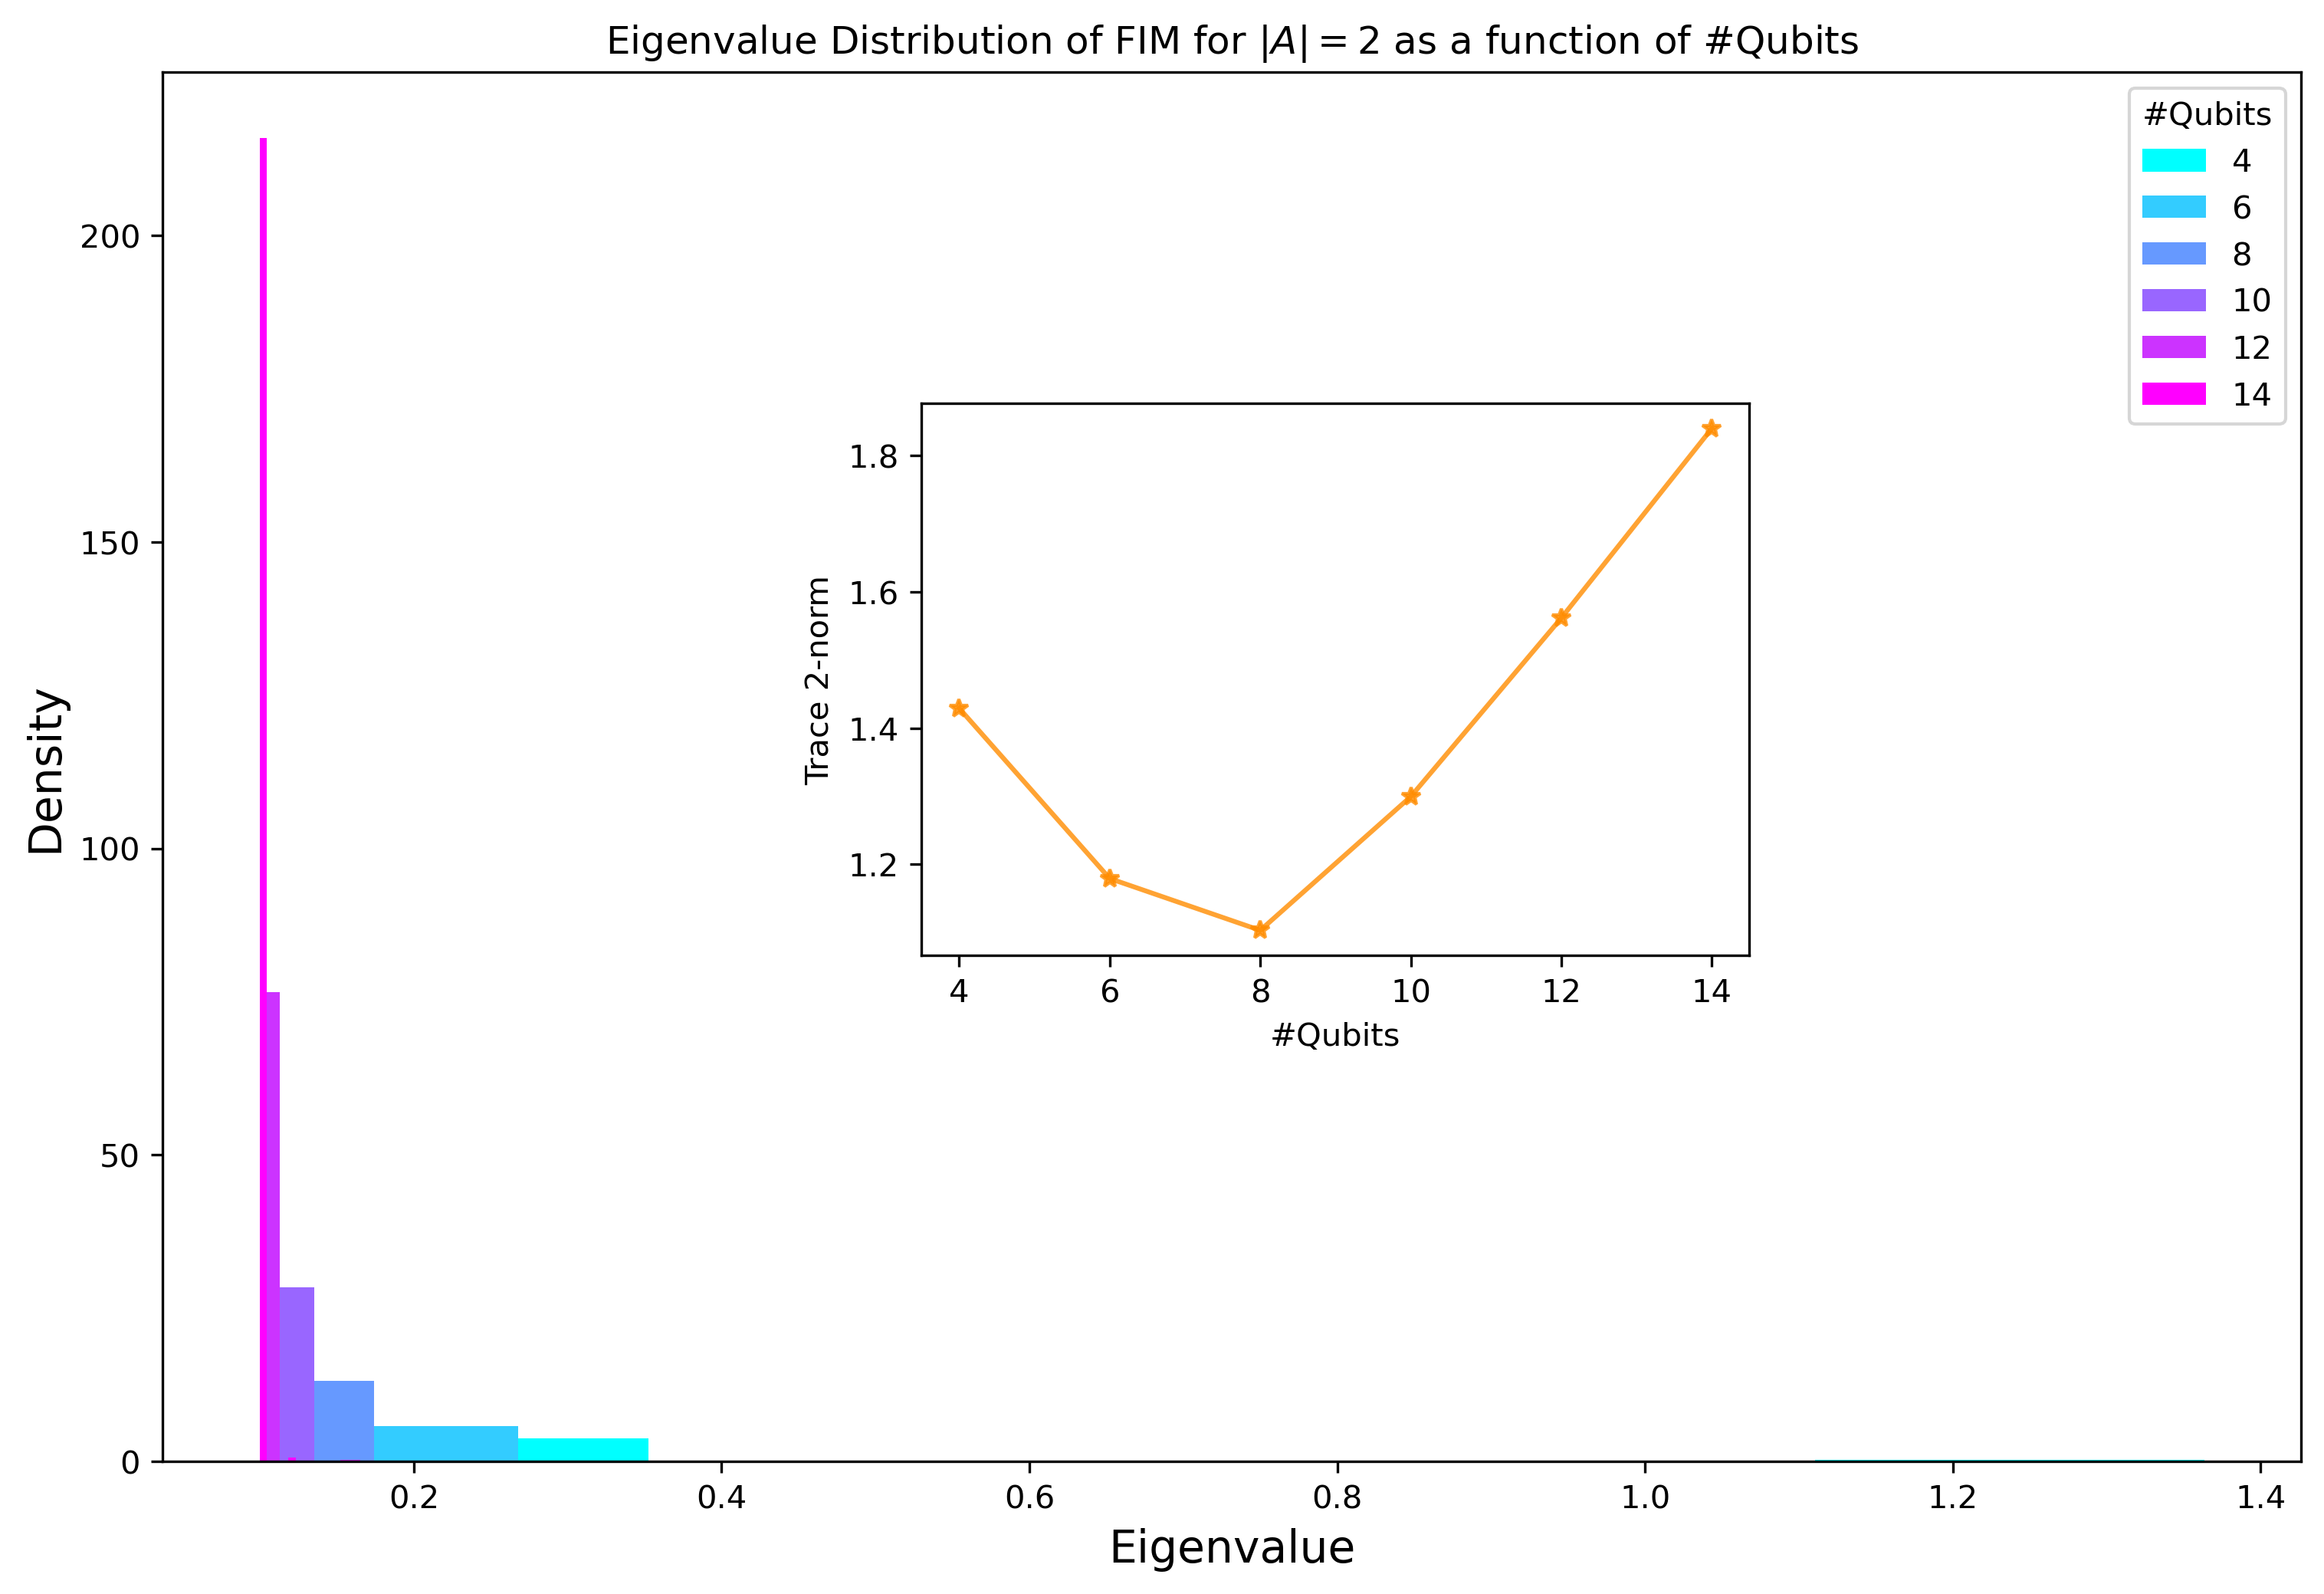

In [32]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

qubits = [4,6,8,10,12,14]
trace_norms = []
for q in qubits:
    trace_norms.append(np.linalg.norm(fim_eigenvalues[q],2))

# dpi 300
plt.rcParams['figure.dpi'] = 300

# Generate a colormap and create a color iterator
colormap = plt.cm.cool
color_iterator = iter(colormap(np.linspace(0, 1, len(fim_eigenvalues))))

# Plotting
plt.figure(figsize=(12, 8))

# Plot each set of eigenvalues with its corresponding color
for num_qubits, eigenvalues in fim_eigenvalues.items():
    color = next(color_iterator)
    plt.hist(eigenvalues, bins=5, density=True, alpha=1.0, color=color, label=num_qubits)

plt.title('Eigenvalue Distribution of FIM for $|A|=2$ as a function of #Qubits')
plt.xlabel('Eigenvalue', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='#Qubits')

#inset axes for trace_norms
inset_ax = plt.axes([0.4, 0.4, 0.3, 0.3])  # Inset axes [left, bottom, width, height]
inset_ax.plot(qubits,trace_norms, marker='*', color='darkorange',label=r"trace norm",alpha=0.8)
#set x_label and y_label
inset_ax.set_xticks(qubits)
inset_ax.set_xlabel(r"#Qubits",fontsize=10)
inset_ax.set_ylabel(r"Trace 2-norm",fontsize=10)
plt.show()


/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


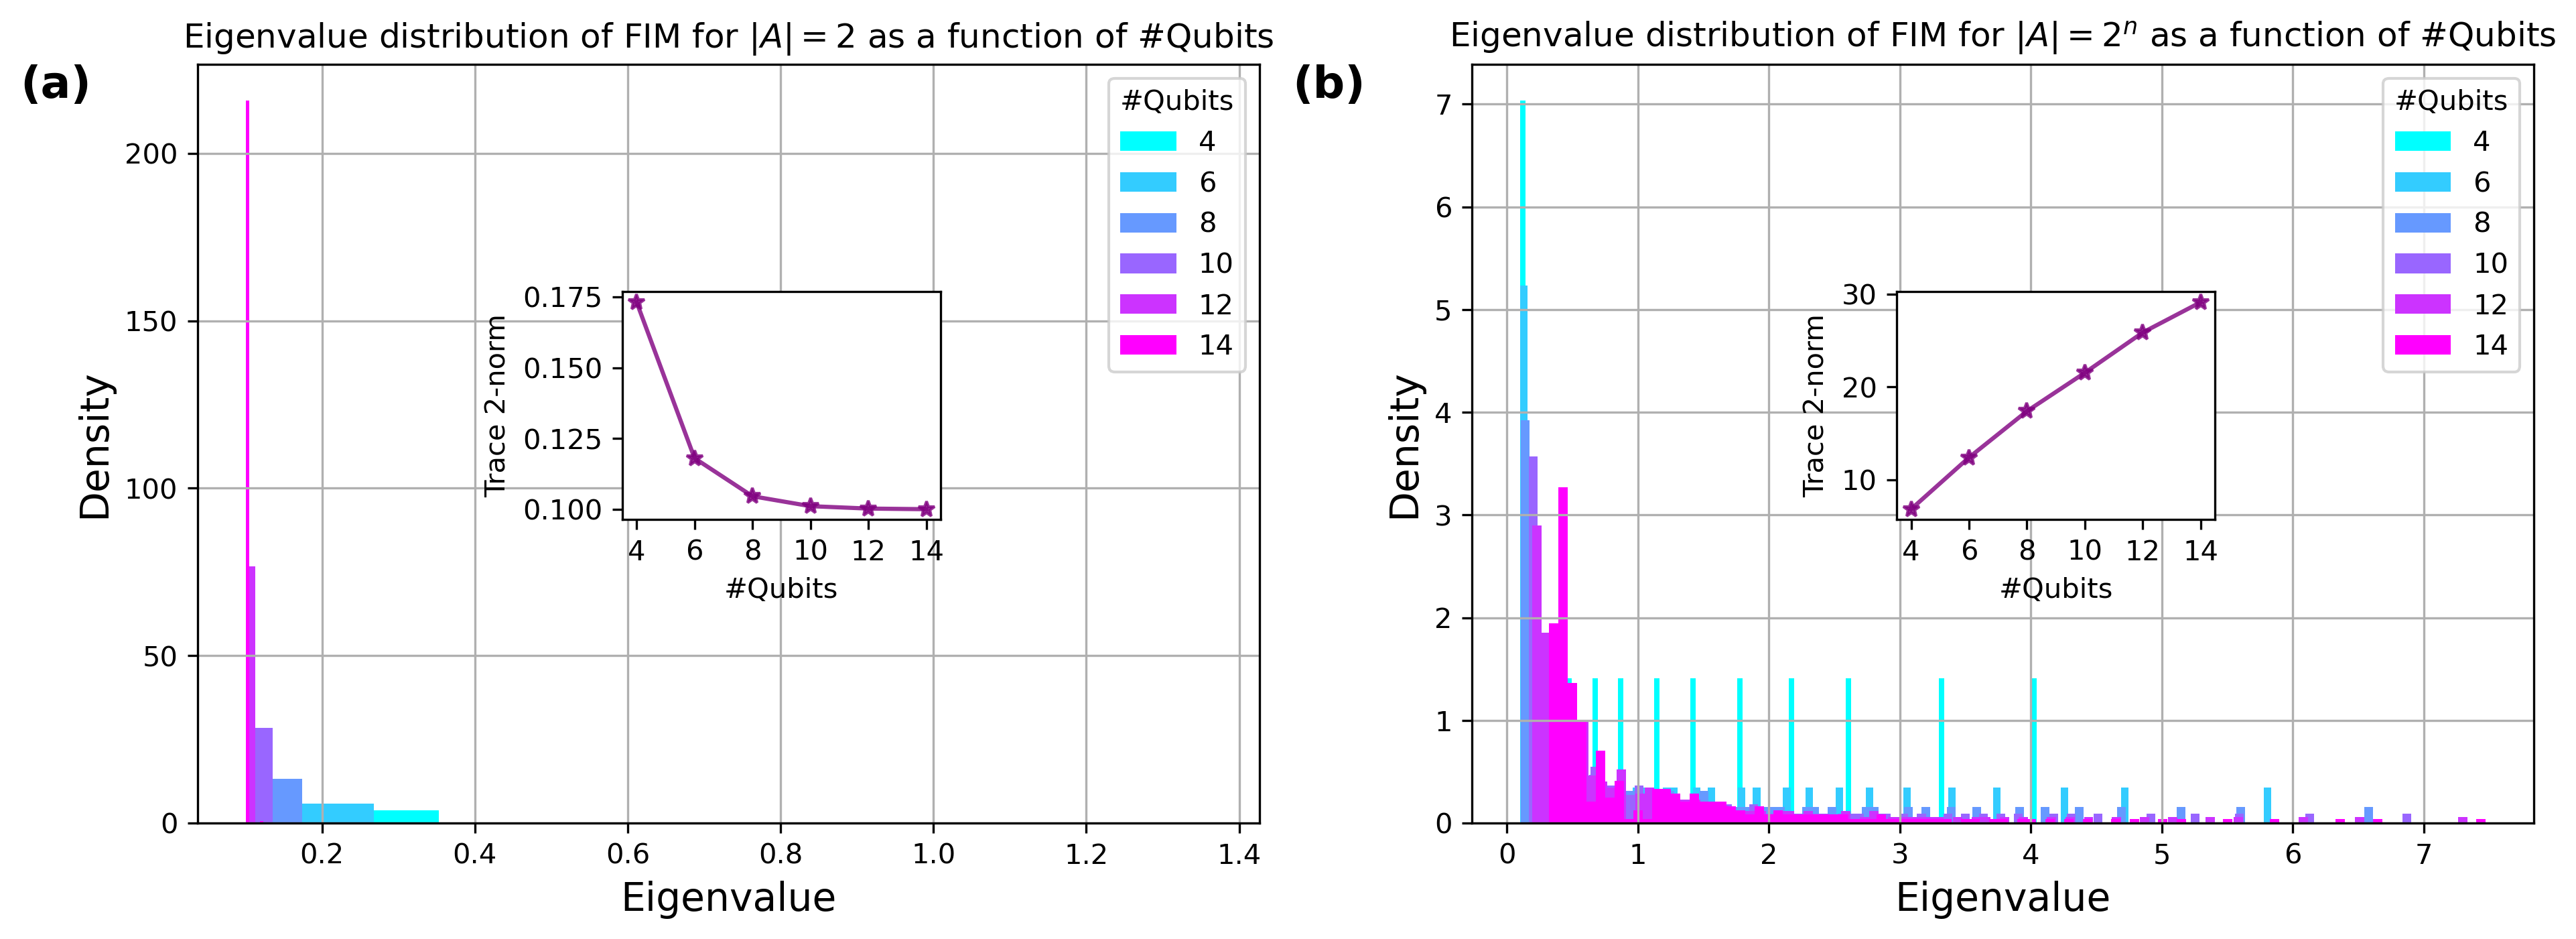

In [9]:
#generate joint subplots for the FIM eigenvalues for the case of |A|=2 and |A|=2^n
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fim_eigenvalues_2 = np.load("fim_eigenvalues_parity-like_|A|=2.npy",allow_pickle=True).item()
fim_eigenvalues_2n = np.load("fim_eigenvalues_parity-like_|A|=2^n_.npy",allow_pickle=True).item()
#fim_eigenvalues_2n = np.load("fim_eigenvalues_parity-like_|A|=2^n_4-14.npy",allow_pickle=True).item()
qubits = [4,6,8,10,12,14]
trace_norms_2 = []
trace_norms_2n = []

for q in qubits:
    trace_norms_2.append(fim_eigenvalues_2[q][0].real.mean())#/len(fim_eigenvalues_2[q]))
    #trace_norms_2n.append(np.median(fim_eigenvalues_2n[q][0].real))#/len(fim_eigenvalues_2n[q]))
    #trace_norms_2.append(np.linalg.norm(fim_eigenvalues_2[q][0].real,ord=2))#,axis=1).real[0])
    trace_norms_2n.append(np.linalg.norm(fim_eigenvalues_2n[q][0].real,ord=2))#,axis=1).real[0])

# dpi 300
plt.rcParams['figure.dpi'] = 300

# Generate a colormap and create a color iterator
colormap = plt.cm.cool
color_iterator = iter(colormap(np.linspace(0, 1, len(fim_eigenvalues_2))))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize as needed

# Plot each set of eigenvalues with its corresponding color
for num_qubits, eigenvalues in fim_eigenvalues_2.items():
    color = next(color_iterator)
    axes[0].hist(eigenvalues, bins=5, density=True, alpha=1.0, color=color, label=num_qubits)

axes[0].set_title('Eigenvalue distribution of FIM for $|A|=2$ as a function of #Qubits')
axes[0].set_xlabel('Eigenvalue', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].legend(title='#Qubits')
axes[0].grid(visible=True,which="both")

#inset axes for trace_norms
inset_ax = axes[0].inset_axes([0.4, 0.4, 0.3, 0.3])  # Inset axes [left, bottom, width, height]
inset_ax.plot(qubits,trace_norms_2, marker='*', color='purple',label=r"trace norm",alpha=0.8)
#set x_label and y_label
inset_ax.set_xticks(qubits)
inset_ax.set_xlabel(r"#Qubits",fontsize=10)
inset_ax.set_ylabel(r"Trace 2-norm",fontsize=10)

# Generate a colormap and create a color iterator
colormap = plt.cm.cool
color_iterator = iter(colormap(np.linspace(0, 1, len(fim_eigenvalues_2n))))

for num_qubits, eigenvalues in fim_eigenvalues_2n.items():
    color = next(color_iterator)
    axes[1].hist(eigenvalues, bins=100, density=True, alpha=1.0, color=color, label=num_qubits)

axes[1].set_title('Eigenvalue distribution of FIM for $|A|=2^n$ as a function of #Qubits')
axes[1].set_xlabel('Eigenvalue', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].legend(title='#Qubits')
axes[1].grid(visible=True,which="both")

#inset axes for trace_norms
inset_ax = axes[1].inset_axes([0.4, 0.4, 0.3, 0.3])  # Inset axes [left, bottom, width, height]
inset_ax.plot(qubits,trace_norms_2n, marker='*', color='purple',label=r"trace norm",alpha=0.8)
#set x_label and y_label
inset_ax.set_xticks(qubits)
inset_ax.set_xlabel(r"#Qubits",fontsize=10)
inset_ax.set_ylabel(r"Trace 2-norm",fontsize=10)

axes[0].text(-0.1, 1.0, '(a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Set label (b) at the top of the second subplot, adjust the coordinates as necessary
axes[1].text(-0.1, 1.0, '(b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


plt.show()




In [50]:
### RY product state 
qubits = [2,4,6,8,10,12,14,16]
n_layers = 5
n_samples = 1000


#var_gradients_qubits = []
var_gradients_no_log = []
var_gradients_log = []

for n_qubits in qubits:
    #var_gradients_actions_log= []
    #var_gradients_actions_no_log = []
    print("-Starting with {} qubits".format(n_qubits))

    #shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    actions = [2**n_qubits]
    
    for n_actions in actions:
        print("---Starting with ",n_actions," actions")
        #gradients = []
        gradients_no_log = []
        gradients_log = []
        for s in range(n_samples):
            
            weights = np.random.uniform(-np.pi,np.pi,size=n_qubits)
            #weights_tensor_params = (2*np.pi)*torch.rand(n_qubits,requires_grad=True) - np.pi
            weights_tensor_params = torch.tensor(weights,requires_grad=True)
            qc = create_circuit(n_qubits,circ="RY")
            measure_qubits = int(np.log2(n_actions))    
            probs = qc(weights_tensor_params, y=False, probs=True, prod=True, entanglement="all_to_all")
            policy = 1
            for p in probs:
                policy*=p[0]
            gradients_log.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))
            gradients_no_log.append(np.linalg.norm(compute_gradient(policy, weights_tensor_params),2))

            #poly(n_qubits) clipping the policy
            #policy = torch.clamp(policy,0.1,1)

            #gradients.append(np.linalg.norm(compute_gradient(torch.log(policy), weights_tensor_params),2))
            #gradients.append(compute_gradient(torch.log(policy), param))
        
        #var_gradients_actions.append(np.var(gradients))
        var_gradients_no_log.append(np.var(gradients_no_log))
        var_gradients_log.append(np.var(gradients_log))
    #var_gradients_qubits.append(var_gradients_actions)
    #var_gradients_no_log.append(var_gradients_actions_no_clamp

-Starting with 2 qubits
---Starting with  4  actions
-Starting with 4 qubits
---Starting with  16  actions
-Starting with 6 qubits
---Starting with  64  actions
-Starting with 8 qubits
---Starting with  256  actions
-Starting with 10 qubits
---Starting with  1024  actions
-Starting with 12 qubits
---Starting with  4096  actions
-Starting with 14 qubits
---Starting with  16384  actions
-Starting with 16 qubits
---Starting with  65536  actions


Text(0, 0.5, '$Var_\\theta [\\nabla_\\theta \\log \\pi]$')

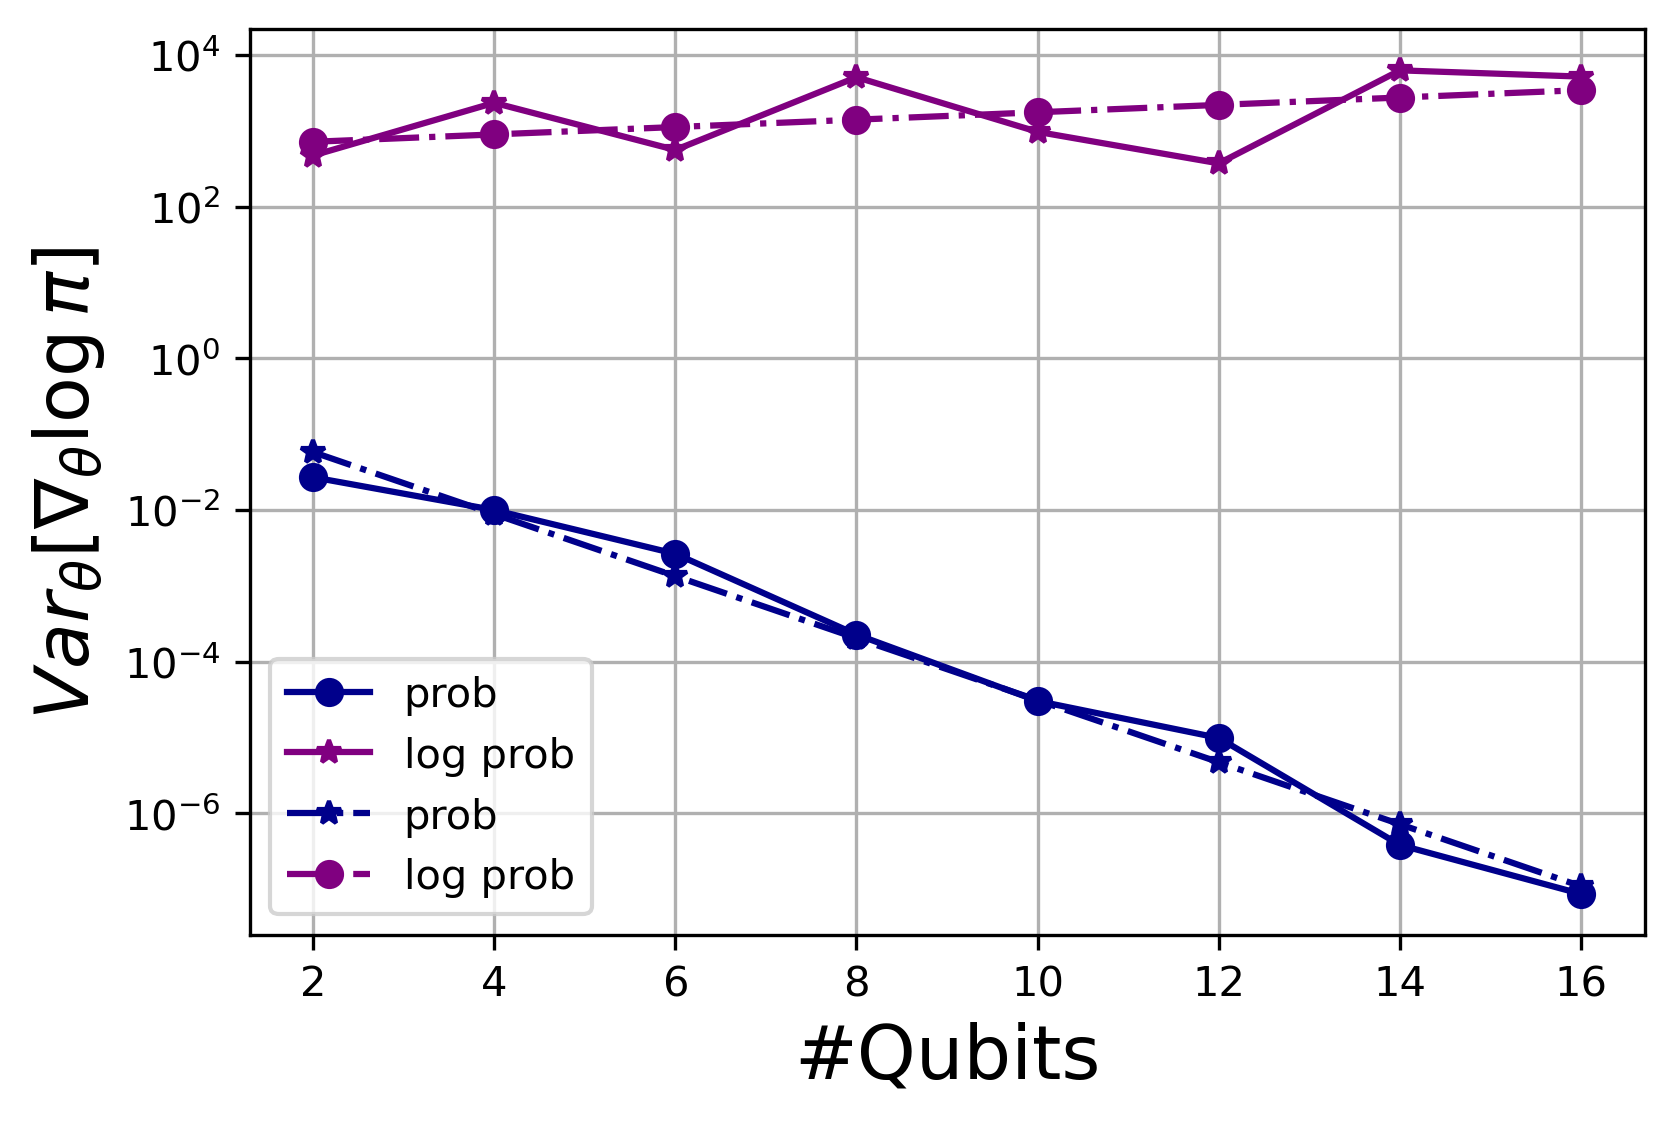

In [51]:
plt.rcParams['figure.dpi'] = 300
plt.plot(qubits, var_gradients_no_log, label="prob",color="darkblue", marker="o")
plt.plot(qubits, var_gradients_log, label="log prob", color="purple", marker="*")
p = np.polyfit(qubits, np.log(var_gradients_no_log), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "*-.", label=f"prob", color="darkblue")
p = np.polyfit(qubits, np.log(var_gradients_log), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), "o-.", label=f"log prob", color="purple")

plt.legend()
plt.grid()
plt.xlabel(r"#Qubits",fontsize=18)
plt.ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)

### SEL layer 

In [4]:
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import os

from helper import compute_gradient_for_sample

# Main part of the code
qubits = [2,4,6,8,10,12,14]
n_layers = 5
n_samples = 1000

var_gradients_no_clamp = []

for n_qubits in qubits:
    var_gradients_actions_no_clamp = []
    print(f"-Starting with {n_qubits} qubits")

    shapes = qml.StronglyEntanglingLayers.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    #actions = {q: [2**i for i in range(1, n_qubits)] for q in qubits}
    actions = {q: [2**n_qubits] for q in qubits}

    for n_actions in actions[n_qubits]:
        print(f"---Starting with {n_actions} actions")
        gradients_no_clamp = []

        # Parallel processing
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
            future_to_gradient = {executor.submit(compute_gradient_for_sample, (n_qubits, shapes, "SEL")): s for s in range(n_samples)}
            for future in concurrent.futures.as_completed(future_to_gradient):
                gradients_no_clamp.append(future.result())

        var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))

    var_gradients_no_clamp.append(var_gradients_actions_no_clamp)

# var_gradients_no_clamp now contains the results


-Starting with 2 qubits
---Starting with 4 actions


-Starting with 4 qubits
---Starting with 16 actions
-Starting with 6 qubits
---Starting with 64 actions
-Starting with 8 qubits
---Starting with 256 actions
-Starting with 10 qubits
---Starting with 1024 actions
-Starting with 12 qubits
---Starting with 4096 actions
-Starting with 14 qubits
---Starting with 16384 actions


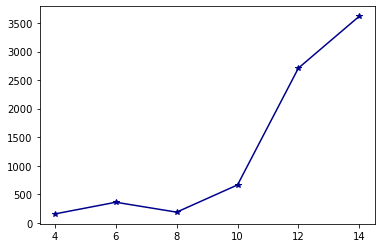

In [6]:
plt.plot(qubits[1:], var_gradients_no_clamp[1:], label=f"{n_qubits} qubits", marker='*', color="darkblue")

In [7]:
np.save("var_gradients_SEL_born_global.npy", var_gradients_no_clamp)

### Random layers 

In [14]:
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import os

from helper import compute_gradient_for_sample

# Main part of the code
qubits = [2,4,6,8,10,12,14]
n_layers = 5
n_samples = 1000

var_gradients_no_clamp = []

for n_qubits in qubits:
    var_gradients_actions_no_clamp = []
    print(f"-Starting with {n_qubits} qubits")

    #shapes = qml.StronglyEntanglingLayers.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    shapes = qml.RandomLayers.shape(n_layers=n_qubits-1,n_rotations=n_qubits**2)
    #actions = {q: [2**i for i in range(1, n_qubits)] for q in qubits}
    actions = {q: [2**n_qubits] for q in qubits}
    for n_actions in actions[n_qubits]:
        print(f"---Starting with {n_actions} actions")
        gradients_no_clamp = []

        # Parallel processing
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
            future_to_gradient = {executor.submit(compute_gradient_for_sample, (n_qubits, shapes, "RL")): s for s in range(n_samples)}
            for future in concurrent.futures.as_completed(future_to_gradient):
                gradients_no_clamp.append(future.result())

        var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))

    var_gradients_no_clamp.append(var_gradients_actions_no_clamp)

# var_gradients_no_clamp now contains the results


-Starting with 2 qubits
---Starting with 4 actions
-Starting with 4 qubits
---Starting with 16 actions
-Starting with 6 qubits
---Starting with 64 actions
-Starting with 8 qubits
---Starting with 256 actions
-Starting with 10 qubits
---Starting with 1024 actions
-Starting with 12 qubits
---Starting with 4096 actions
-Starting with 14 qubits
---Starting with 16384 actions


In [16]:
np.save("var_gradients_RL_born_global.npy", var_gradients_no_clamp)

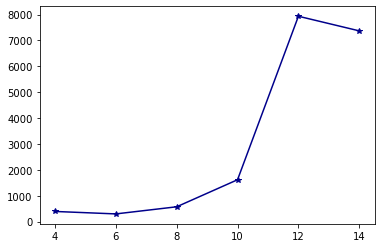

In [15]:
plt.plot(qubits, var_gradients_no_clamp, label=f"{n_qubits} qubits", marker='*', color="darkblue")


### S2D

In [32]:
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import os

from helper import compute_gradient_for_sample_s2d

# Main part of the code
qubits = [4,6,8,10,12,14]
n_layers = 5
n_samples = 1000

var_gradients_no_clamp = []

for n_qubits in qubits:
    var_gradients_actions_no_clamp = []
    print(f"-Starting with {n_qubits} qubits")

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits*2, n_wires=n_qubits)
    actions = {q: [2**q] for q in qubits}

    for n_actions in actions[n_qubits]:
        print(f"---Starting with {n_actions} actions")
        gradients_no_clamp = []

        # Parallel processing
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
            future_to_gradient = {executor.submit(compute_gradient_for_sample_s2d, (n_qubits, shapes, "simplified_two_design")): s for s in range(n_samples)}
            for future in concurrent.futures.as_completed(future_to_gradient):
                gradients_no_clamp.append(future.result())

        var_gradients_actions_no_clamp.append(np.var(gradients_no_clamp))

    var_gradients_no_clamp.append(var_gradients_actions_no_clamp)

-Starting with 4 qubits
---Starting with 16 actions
-Starting with 6 qubits
---Starting with 64 actions
-Starting with 8 qubits
---Starting with 256 actions
-Starting with 10 qubits
---Starting with 1024 actions
-Starting with 12 qubits
---Starting with 4096 actions
-Starting with 14 qubits
---Starting with 16384 actions


In [33]:
np.save("var_gradients_s2d_born_global.npy", var_gradients_no_clamp)

[ 390.5989271   295.14648192  570.69239597 1616.31937049 7937.81538162
 7372.04462995]


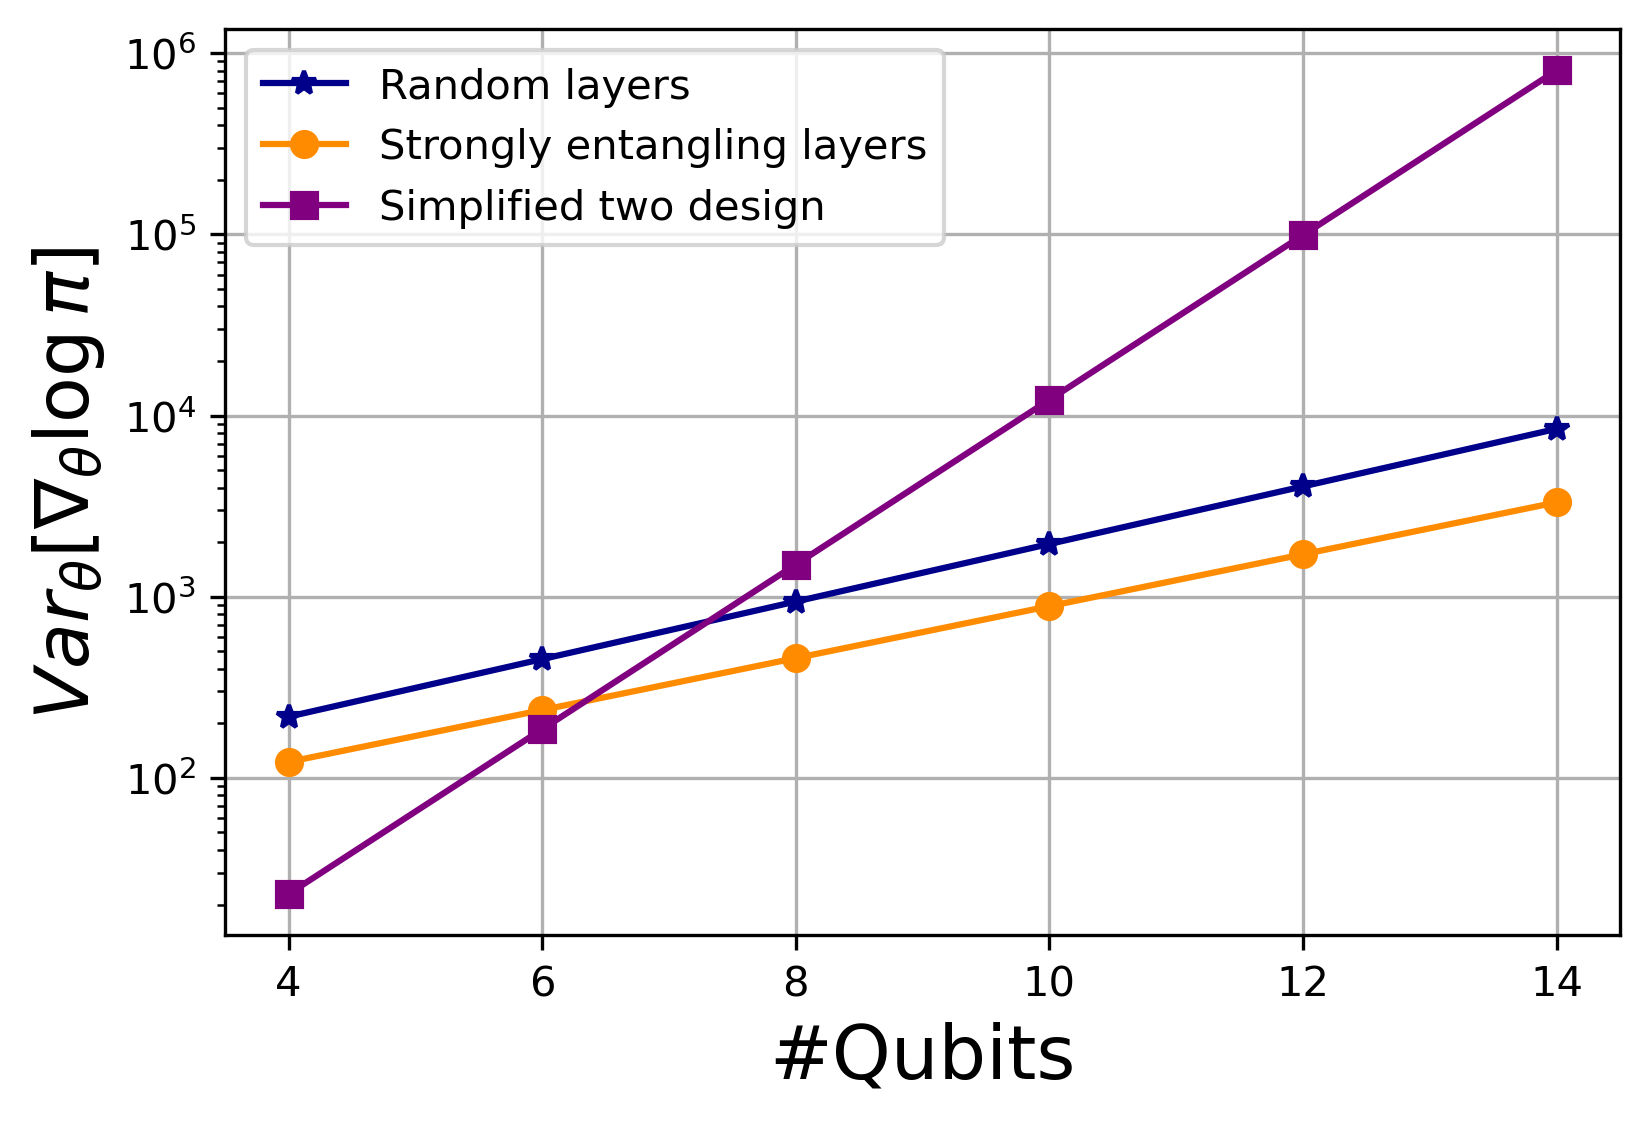

In [36]:
#generate joint subplots for the FIM eigenvalues for the case of |A|=2 and |A|=2^n
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

var_sel = np.load("var_gradients_SEL_born_global.npy")[1:].flatten()
var_rl = np.load("var_gradients_RL_born_global.npy")[1:].flatten()
#var_s2d = np.load("var_gradients_s2d_born_global.npy")
var_gradients_no_c = np.load("var_gradients_contiguous_no_clamp_f(A).npy",allow_pickle=True)

qubits = [4,6,8,10,12,14]

var_s2d_ = []
for i in range(len(var_gradients_no_c)):
    var_s2d_.append(var_gradients_no_c[i][-1])

'''
var_s2d_ = []
for i in range(len(var_s2d)):
    var_s2d_.append(var_s2d[i][-1])

var_s2d_ = np.array(var_s2d_).flatten()
'''
plt.rcParams['figure.dpi'] = 300

# Define a list of markers
markers = ['o', '^', 's', 'p', '*', 'x', '+', 'D']

# Define a colormap
qubits = [4,6,8,10,12,14]

num_qubits = len(qubits)
print(var_rl)
#plot random layers
#plt.plot(qubits, var_rl, marker="*", color="darkblue" , alpha=0.3)
p = np.polyfit(qubits, np.log(var_rl), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), label="Random layers", marker="*", color="darkblue")

#plot strongly entangling layers
#plt.plot(qubits, var_sel, marker="o", color="darkorange", alpha=0.3)
p = np.polyfit(qubits, np.log(var_sel), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), label="Strongly entangling layers", marker="o", color="darkorange")

#plot simplified two design
#plt.plot(qubits, var_s2d_, marker="s", color="purple", alpha=0.3)
p = np.polyfit(qubits, np.log(var_s2d_), 1)
plt.semilogy(qubits, np.exp(p[0] * np.array(qubits) + p[1]), label="Simplified two design", marker="s", color="purple")

plt.legend()
plt.grid()
plt.xlabel(r"#Qubits",fontsize=18)
plt.ylabel(r"$Var_\theta [\nabla_\theta \log \pi]$",fontsize=18)
plt.show()



In [41]:
qubits = [10,12,14]
n_layers = 5
n_samples = 1


#fim_eigenvalues = {}
fim_norm=[]

for n_qubits in qubits:
    fim_actions = []
    print("-Starting with {} qubits".format(n_qubits))

    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_qubits-1, n_wires=n_qubits)
    actions = [2**n_qubits]
    
    for n_actions in actions:
        print("---Starting with ",n_actions," actions")
        fim_eigvals = []
        for s in range(n_samples):
        
            weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]
            weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
            weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
            qc = create_circuit(n_qubits,circ="simplified_two_design",fim=True)
            measure_qubits = int(np.log2(n_actions))    
            probs = qc(weights_tensor_init, weights_tensor_params, measurement_qubits=measure_qubits)
            pi = policy(probs, policy_type="parity-like", n_actions=n_actions)
            fim = FIM(pi, weights_tensor_params)
            fim_eigvals.append(np.linalg.eigvals(fim))
        fim_actions.append(np.mean(fim_eigvals,0))
    fim_eigenvalues[n_qubits] = fim_actions


-Starting with 10 qubits
---Starting with  1024  actions
-Starting with 12 qubits
---Starting with  4096  actions


KeyboardInterrupt: 

In [27]:
np.save("fim_eigenvalues_contiguous-like_|A|=2.npy",fim_eigenvalues)

/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


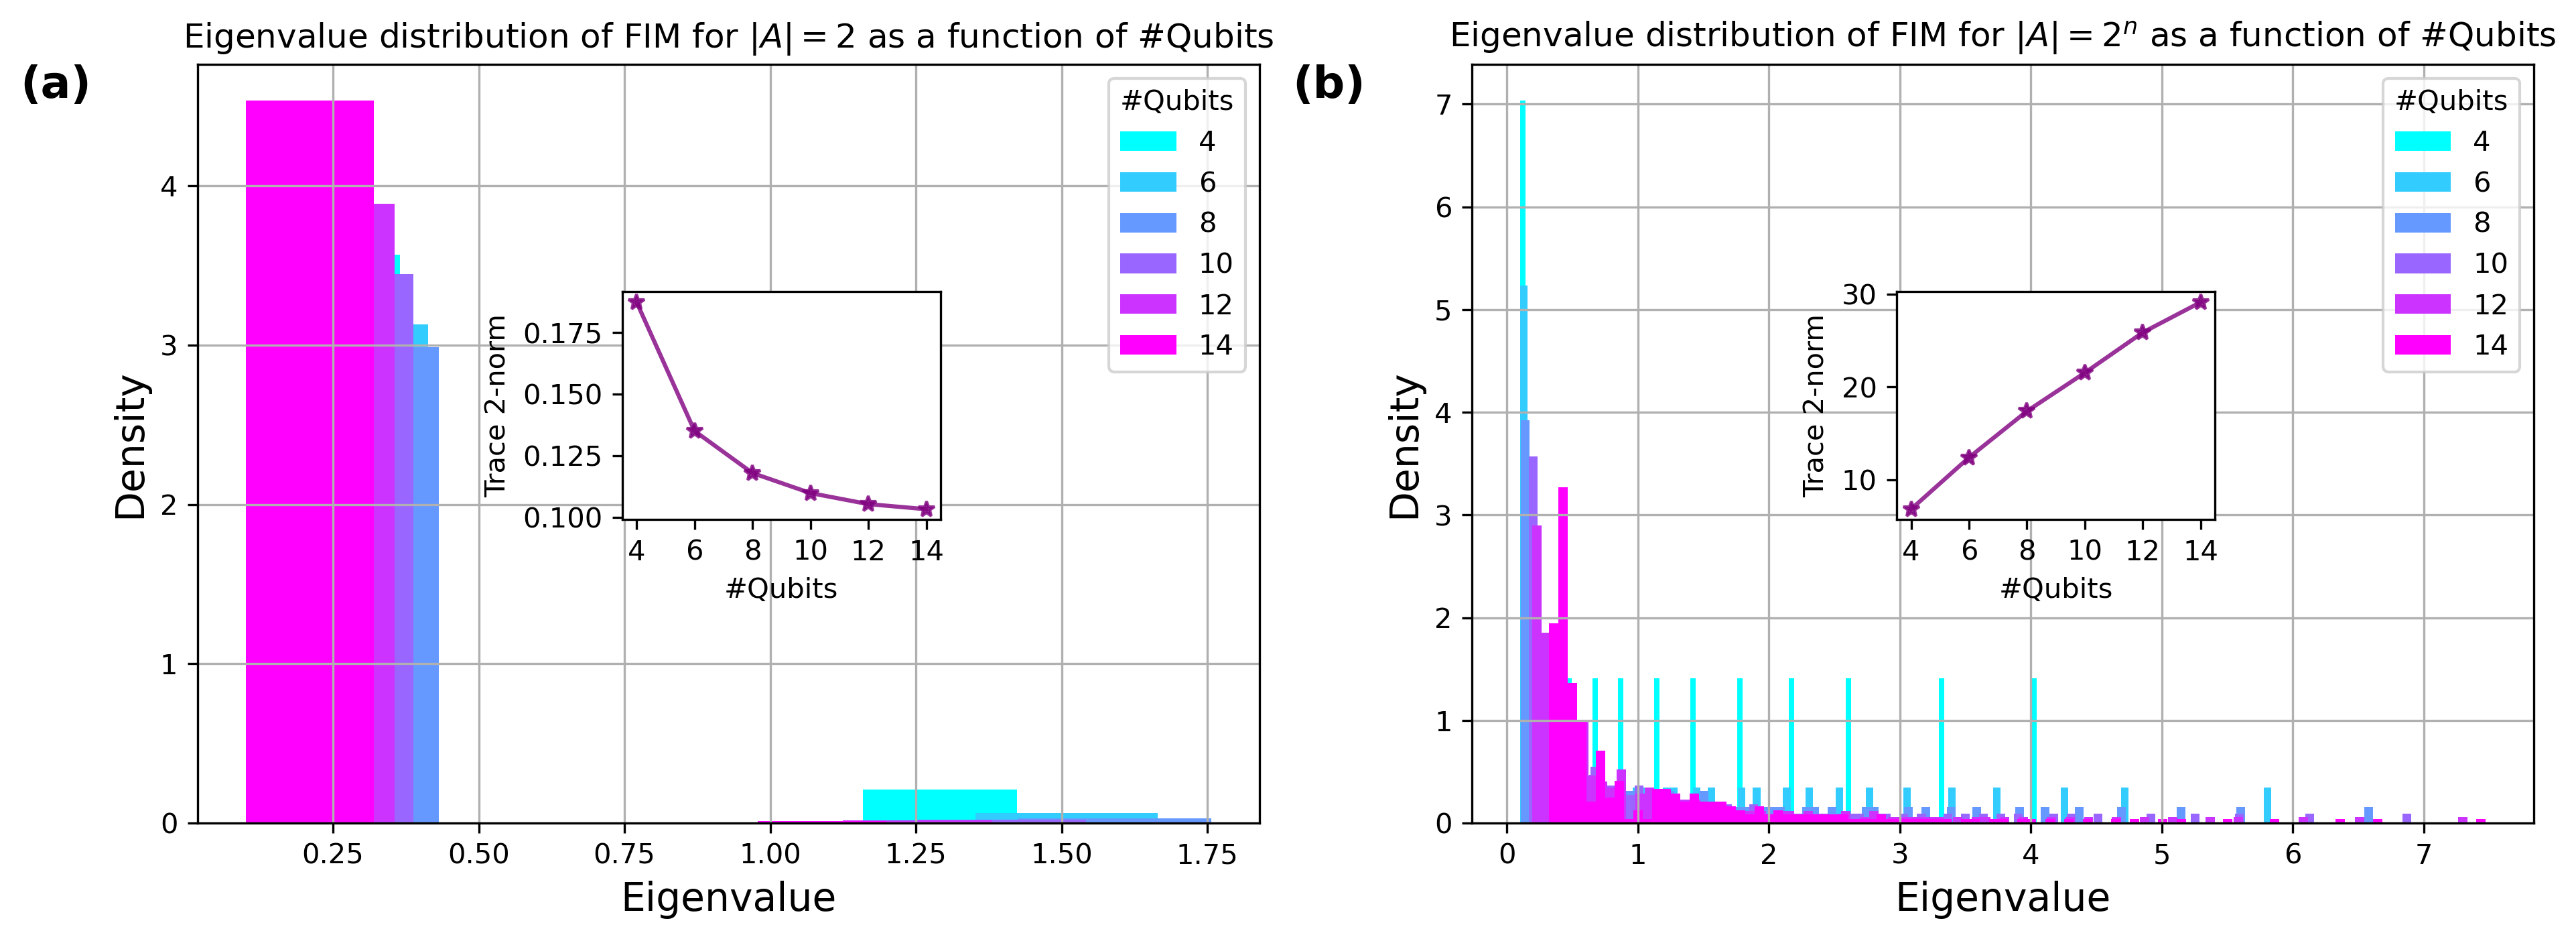

In [28]:
#generate joint subplots for the FIM eigenvalues for the case of |A|=2 and |A|=2^n
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fim_eigenvalues_2 = np.load("fim_eigenvalues_contiguous-like_|A|=2.npy",allow_pickle=True).item()
fim_eigenvalues_2n = np.load("fim_eigenvalues_parity-like_|A|=2^n_.npy",allow_pickle=True).item()
#fim_eigenvalues_2n = np.load("fim_eigenvalues_parity-like_|A|=2^n_4-14.npy",allow_pickle=True).item()
qubits = [4,6,8,10,12,14]
trace_norms_2 = []
trace_norms_2n = []

for q in qubits:
    trace_norms_2.append(fim_eigenvalues_2[q][0].real.mean())#/len(fim_eigenvalues_2[q]))
    #trace_norms_2n.append(np.median(fim_eigenvalues_2n[q][0].real))#/len(fim_eigenvalues_2n[q]))
    #trace_norms_2.append(np.linalg.norm(fim_eigenvalues_2[q][0].real,ord=2))#,axis=1).real[0])
    trace_norms_2n.append(np.linalg.norm(fim_eigenvalues_2n[q][0].real,ord=2))#,axis=1).real[0])

# dpi 300
plt.rcParams['figure.dpi'] = 600

# Generate a colormap and create a color iterator
colormap = plt.cm.cool
color_iterator = iter(colormap(np.linspace(0, 1, len(fim_eigenvalues_2))))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figsize as needed

# Plot each set of eigenvalues with its corresponding color
for num_qubits, eigenvalues in fim_eigenvalues_2.items():
    color = next(color_iterator)
    axes[0].hist(eigenvalues, bins=5, density=True, alpha=1.0, color=color, label=num_qubits)

axes[0].set_title('Eigenvalue distribution of FIM for $|A|=2$ as a function of #Qubits')
axes[0].set_xlabel('Eigenvalue', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].legend(title='#Qubits')
axes[0].grid(visible=True,which="both")

#inset axes for trace_norms
inset_ax = axes[0].inset_axes([0.4, 0.4, 0.3, 0.3])  # Inset axes [left, bottom, width, height]
inset_ax.plot(qubits,trace_norms_2, marker='*', color='purple',label=r"trace norm",alpha=0.8)
#set x_label and y_label
inset_ax.set_xticks(qubits)
inset_ax.set_xlabel(r"#Qubits",fontsize=10)
inset_ax.set_ylabel(r"Trace 2-norm",fontsize=10)

# Generate a colormap and create a color iterator
colormap = plt.cm.cool
color_iterator = iter(colormap(np.linspace(0, 1, len(fim_eigenvalues_2n))))

for num_qubits, eigenvalues in fim_eigenvalues_2n.items():
    color = next(color_iterator)
    axes[1].hist(eigenvalues, bins=100, density=True, alpha=1.0, color=color, label=num_qubits)

axes[1].set_title('Eigenvalue distribution of FIM for $|A|=2^n$ as a function of #Qubits')
axes[1].set_xlabel('Eigenvalue', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].legend(title='#Qubits')
axes[1].grid(visible=True,which="both")

#inset axes for trace_norms
inset_ax = axes[1].inset_axes([0.4, 0.4, 0.3, 0.3])  # Inset axes [left, bottom, width, height]
inset_ax.plot(qubits,trace_norms_2n, marker='*', color='purple',label=r"trace norm",alpha=0.8)
#set x_label and y_label
inset_ax.set_xticks(qubits)
inset_ax.set_xlabel(r"#Qubits",fontsize=10)
inset_ax.set_ylabel(r"Trace 2-norm",fontsize=10)

axes[0].text(-0.1, 1.0, '(a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Set label (b) at the top of the second subplot, adjust the coordinates as necessary
axes[1].text(-0.1, 1.0, '(b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


plt.show()


